# Brownian Dynamics Results Analyis
This code was created by Marcus Hock in order to analyze the Brownian Dynamics simulations carried out between myosin and actin. The myosin conformations generated from MSM model construction and analysis, with frames sampled from the different metastable states. 

This analysis is based upon simulations carried out with [Browndye 2.0](https://browndye.ucsd.edu/) using an undefined reaction binding distance, therefore the outputs are frequently considered as binding curves. 

In [1]:
# Import necessary modules 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mdtraj as md
import seaborn as sns
from sklearn.decomposition import PCA
import seaborn as sns
from scipy import stats
from tqdm import tqdm 
import pickle 
import os 
import datetime
import pyemma
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


# Make sure the pdfs and SVG's are editable

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# Define two base colors
colors = ['#332288','#44AA99']

# List of HEX colors for ADP 
ADP_colors = ['#8063FF', '#332288', '#281E50']

# List of HEX colors for dADP 
dADP_colors = ['#58E9D3', '#44AA99', '#22564E']

# Full list for the potential different metastable states 
combined_colors= ['#8063FF', '#332288', '#281E50','#58E9D3', '#44AA99', '#22564E']

In [3]:
# Define a class for each iteration of a BD simulation for a metastable state 
# When initialized, when pointing to 

class BD_simulation:
    def __init__(self, simulation_directory, name = ''):
        self.sim_dir = simulation_directory
        self.sim_list = []
        self.pair_list = []
        self.pdb_list = []
        self.complete_pairs = None
        self.sim_name = name
        # Load each simulation
        for i in range(1,15+1):
            #try:
            full_file_path = self.sim_dir + '/cluster_{i}/output_rates.txt'.format(i=i)
            self.sim_list.append(pd.read_csv(full_file_path,delimiter = ' ', names = ['distance','low','average','high']))

            pair_file_path = self.sim_dir + '/cluster_{i}/reaction_pairs.xml'.format(i=i)

            # Load in originally constructed reaction pairs
            temp = pd.read_csv(pair_file_path,
                names = ['pair','myosin','actin','fake_pair'],
                skiprows=1, 
                skipfooter = 1,
                delim_whitespace = True,
                engine = 'python',
                index_col = False,
                )
            temp['combined'] = ''
            for x in temp.index:
                temp.loc[x,'combined'] = (str(temp.myosin[x])+" "+str(temp.actin[x]))
            self.pair_list.append(temp)

            # Load in pdb files for myosin
            pdb_dir = self.sim_dir + '/aligned_structures/myosin_{i}.pqr'.format(i=i)
            self.pdb_list.append(md.load_pdb(pdb_dir))
            #except:
            #   self.sim_list.append(self.sim_list[i-1])
            
        # Load in the entire pair reaction criteria
        pair_file_path = self.sim_dir + '/cluster_{i}/new_reaction_pairs.xml'.format(i=i)
        temp = pd.read_csv(pair_file_path,
            names = ['pair','myosin','actin','fake_pair'],
            skiprows=1, 
            skipfooter = 1,
            delim_whitespace = True,
            engine = 'python',
            index_col = False,
            )
        temp['combined'] = ''
        for x in temp.index:
            temp.loc[x,'combined'] = (str(temp.myosin[x])+" "+str(temp.actin[x]))
        self.complete_pairs= temp
        
        
        
        
    def plot_all(self, color = 'C0', ax = None, label = None):
        if ax == None:
            if label == None: 
                for i in range(len(self.sim_list)):
                    plt.plot(self.sim_list[i].distance, self.sim_list[i].average, color = color)
            else: 
                i = 0
                plt.plot(self.sim_list[i].distance, self.sim_list[i].average, color = color, label = label)
                for i in range(1,len(self.sim_list)):
                    plt.plot(self.sim_list[i].distance, self.sim_list[i].average, color = color)

                    
        else:
            if label == None:
                for i in range(len(self.sim_list)):
                    ax.plot(self.sim_list[i].distance, self.sim_list[i].average, color = color)
            else:
                i = 0 
                ax.plot(self.sim_list[i].distance, self.sim_list[i].average, color = color, label = label)
                for i in range(1,len(self.sim_list)):
                    ax.plot(self.sim_list[i].distance, self.sim_list[i].average, color = color)

    
    def calc_average(self, xmin=4, xmax=100):
        av = np.zeros(1000)
        self.distance_range = np.linspace(xmin,xmax,1000)
        input_df = self.sim_list
        for i in range(15):
            distance_array = input_df[i].distance
            rates_array = input_df[i].average
            interp = np.interp(self.distance_range, distance_array, rates_array)
            av += 1/15*interp 
        self.average = av



In [4]:
# Load in simulations results for the ADP myosin metastable state simulations 

ADP_0 = BD_simulation('bd_adp/metastable_0/', name = 'ADP_0')
ADP_1 = BD_simulation('bd_adp/metastable_1/', name = 'ADP_1')
ADP_2 = BD_simulation('bd_adp/metastable_2/', name = 'ADP_2')


In [6]:
# Load in simulations results for the ADP myosin metastable state simulations 

dADP_0 = BD_simulation('bd_dadp/metastable_0/', name = 'dADP_0')
dADP_1 = BD_simulation('bd_dadp/metastable_1/', name = 'dADP_1')
dADP_2 = BD_simulation('bd_dadp/metastable_2/', name = 'dADP_2')


In [8]:
# Calcualte the average binding curve for each of the metatsble state based on the sampled frames

# Calcualte ADP averages
ADP_0.calc_average()
ADP_1.calc_average()
ADP_2.calc_average()

# Calcualte dADP averages
dADP_0.calc_average()
dADP_1.calc_average()
dADP_2.calc_average()


In [11]:
# Estimate the overall weighted binding rate based on stationary distribution calculated in the MSM analysis. 

# Define weights from MSM stationary distributions
ADP_stationary_dist = [0.34129691367149756, 0.40686952769607276, 0.25183355863242973]

dADP_stationary_dist = [0.04998596184205902, 0.08170875637656712, 0.8683052817813737]

# Estimate weighted average 
ADP_averaged = ADP_stationary_dist[0] * ADP_0.average + ADP_stationary_dist[1] * ADP_1.average + ADP_stationary_dist[2] * ADP_2.average

dADP_averaged = dADP_stationary_dist[0] * dADP_0.average + dADP_stationary_dist[1] * dADP_1.average + dADP_stationary_dist[2] * dADP_2.average

Text(0.5, 1.0, 'Comparison of Metastable Average Browndye Binding Curves')

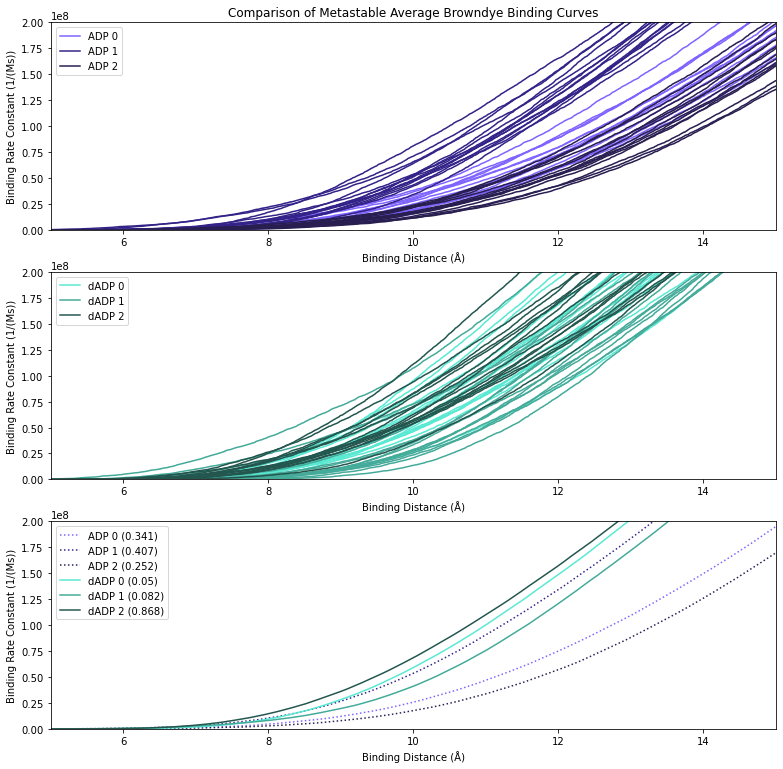

In [10]:
fig, ax = plt.subplots(3,1,figsize = (13, 13))


ADP_0.plot_all(color = ADP_colors[0], label = 'ADP 0', ax = ax[0])
ADP_1.plot_all(color = ADP_colors[1], label = 'ADP 1', ax = ax[0])
ADP_2.plot_all(color = ADP_colors[2], label = 'ADP 2', ax = ax[0])

dADP_0.plot_all(color = dADP_colors[0], label = 'dADP 0', ax = ax[1])
dADP_1.plot_all(color = dADP_colors[1], label = 'dADP 1', ax = ax[1])
dADP_2.plot_all(color = dADP_colors[2], label = 'dADP 2', ax = ax[1])

plt.plot(ADP_0.distance_range, ADP_0.average, ':', label = 'ADP 0 ({})'.format(np.round(ADP_stationary_dist[0],3)), color = ADP_colors[0])
plt.plot(ADP_1.distance_range, ADP_1.average, ':',label = 'ADP 1 ({})'.format(np.round(ADP_stationary_dist[1],3)), color = ADP_colors[1])
plt.plot(ADP_2.distance_range, ADP_2.average, ':',label = 'ADP 2 ({})'.format(np.round(ADP_stationary_dist[2],3)), color = ADP_colors[2])

plt.plot(dADP_0.distance_range, dADP_0.average, label = 'dADP 0 ({})'.format(np.round(dADP_stationary_dist[0],3)), color = dADP_colors[0])
plt.plot(dADP_1.distance_range, dADP_1.average, label = 'dADP 1 ({})'.format(np.round(dADP_stationary_dist[1],3)), color = dADP_colors[1])
plt.plot(dADP_2.distance_range, dADP_2.average, label = 'dADP 2 ({})'.format(np.round(dADP_stationary_dist[2],3)), color = dADP_colors[2])


for i in range(3):
    ax[i].legend(loc = 'upper left')

    ax[i].set_xlim(5,15)
    ax[i].legend()

    ax[i].set_ylim(0,2e8)
    

    ax[i].set_xlabel('Binding Distance (Å)')
    ax[i].set_ylabel('Binding Rate Constant (1/(Ms))')

ax[0].set_title('ADP Browndye Binding Curves')
ax[0].set_title('ADP Browndye Binding Curves')
ax[0].set_title('Comparison of Metastable Average Browndye Binding Curves')




NameError: name 'x_range' is not defined

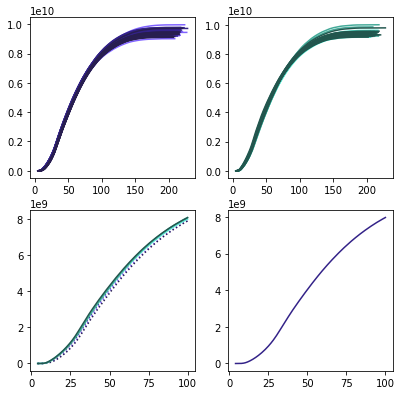

In [22]:
fig, ax = plt.subplots(2,2,figsize = (6.5, 6.5))


ADP_0.plot_all(color = ADP_colors[0], label = 'ADP 0', ax = ax[0,0])
ADP_1.plot_all(color = ADP_colors[1], label = 'ADP 1', ax = ax[0,0])
ADP_2.plot_all(color = ADP_colors[2], label = 'ADP 2', ax = ax[0,0])

dADP_0.plot_all(color = dADP_colors[0], label = 'dADP 0', ax = ax[0,1])
dADP_1.plot_all(color = dADP_colors[1], label = 'dADP 1', ax = ax[0,1])
dADP_2.plot_all(color = dADP_colors[2], label = 'dADP 2', ax = ax[0,1])

ax[1,0].plot(ADP_0.distance_range, ADP_0.average, ':', label = 'ADP 0 ({})'.format(np.round(ADP_stationary_dist[0],3)), color = ADP_colors[0])
ax[1,0].plot(ADP_1.distance_range, ADP_1.average, ':',label = 'ADP 1 ({})'.format(np.round(ADP_stationary_dist[1],3)), color = ADP_colors[1])
ax[1,0].plot(ADP_2.distance_range, ADP_2.average, ':',label = 'ADP 2 ({})'.format(np.round(ADP_stationary_dist[2],3)), color = ADP_colors[2])

ax[1,0].plot(dADP_0.distance_range, dADP_0.average, label = 'dADP 0 ({})'.format(np.round(dADP_stationary_dist[0],3)), color = dADP_colors[0])
ax[1,0].plot(dADP_1.distance_range, dADP_1.average, label = 'dADP 1 ({})'.format(np.round(dADP_stationary_dist[1],3)), color = dADP_colors[1])
ax[1,0].plot(dADP_2.distance_range, dADP_2.average, label = 'dADP 2 ({})'.format(np.round(dADP_stationary_dist[2],3)), color = dADP_colors[2])






ax[1,1].plot(ADP_0.distance_range, ADP_averaged, label = 'ATP Binding Curve', c= colors[0])
ax[1,1].plot(x_range, lower_ADP, c = colors[0], alpha = 0.5)
ax[1,1].plot(x_range, upper_ADP, c = colors[0], alpha = 0.5)

ax[1,1].plot(dADP_0.distance_range, dADP_averaged, label = 'dATP Binding Curve', c= colors[1])
ax[1,1].plot((0, exp_distance),(2.5e6,2.5e6),':', c = colors[0], label = 'ATP Experimental Binding Rate')
ax[1,1].plot((exp_distance, exp_distance),(0,1e8),':r', label = 'Estimated binding distance ')

ax[1,1].plot((0,exp_distance),(dADP_rate,dADP_rate),':', c=colors[1], label = 'dATP Estimated Binding Rate')
ax[1,1].plot(x_range, lower_dADP, c = colors[1], alpha = 0.5)
ax[1,1].plot(x_range, upper_dADP, c = colors[1], alpha = 0.5)



for i in range(4):
    ax[i//2, i % 2].legend(loc = 'upper left')

    ax[i//2, i % 2].set_xlim(5,15)
    ax[i//2, i % 2].legend(frameon = False, fontsize = 6, loc = 'lower right')

    ax[i//2, i % 2].set_ylim(0,2e8)
    

    ax[i//2, i % 2].set_xlabel('Binding Distance (Å)', fontsize = 7)
    ax[i//2, i % 2].set_ylabel('Binding Rate Constant (1/(Ms))', fontsize = 7)
    ax[i//2, i % 2].set_yscale('log')
    ax[i//2, i % 2].set_ylim(.5e5,1e8)
    ax[i//2, i % 2].tick_params(axis='both', which='major', labelsize=6)
    ax[i//2, i % 2].tick_params(axis='both', which='minor', labelsize=6)
#    ax[i//2, i % 2].


plt.tight_layout()
# fig.savefig('../figures/all_bd_binding_and_weighted_and_CI.svg')

In [13]:
# Estimate the experimental binding rate based on 
exp_distance = np.interp(2.5e6,ADP_averaged, ADP_0.distance_range )

print(exp_distance)

dADP_rate = np.interp(exp_distance, dADP_0.distance_range, dADP_averaged)

dADP_rate/2.5e6

7.203225892750817


1.9212509368131827

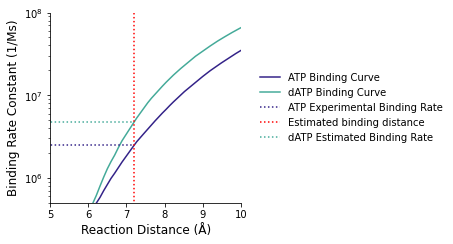

In [14]:
# Create figure for the manuscript to show change in binding rate

fig = plt.figure(figsize = (8.7/2.54,3.5))
plt.plot(ADP_0.distance_range, ADP_averaged, label = 'ATP Binding Curve', c= colors[0])

plt.plot(dADP_0.distance_range, dADP_averaged, label = 'dATP Binding Curve', c= colors[1])
plt.plot((0, exp_distance),(2.5e6,2.5e6),':', c = colors[0], label = 'ATP Experimental Binding Rate')
plt.plot((exp_distance, exp_distance),(0,1e8),':r', label = 'Estimated binding distance ')

plt.plot((0,exp_distance),(dADP_rate,dADP_rate),':', c=colors[1], label = 'dATP Estimated Binding Rate')


plt.legend(loc = 'upper left', fontsize = 9)
plt.xlim(5,10)

plt.yscale('log')
plt.ylim(.5e6,1e8)
plt.xlabel('Reaction Distance (Å)', fontsize = 12)
plt.ylabel('Binding Rate Constant (1/Ms)', fontsize = 12)
lgd = plt.legend(loc='center right', 
           bbox_to_anchor=(2.1, .5),

          ncol=1, fancybox=True, shadow=False, 
          frameon = False)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)



Max fold change:  2.1257532371023298


/tmp/ipykernel_299485/1051763258.py:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(dADP_0.distance_range, dADP_averaged/ADP_averaged, label = 'dADP Binding Curve', c= colors[1])
/tmp/ipykernel_299485/1051763258.py:21: RuntimeWarning: divide by zero encountered in true_divide
  max_fold_change =np.max((dADP_averaged/ADP_averaged)[ADP_0.distance_range>5])


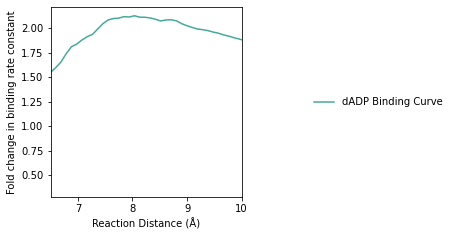

In [20]:
fig = plt.figure(figsize = (8.7/2.54,3.5))


plt.plot(dADP_0.distance_range, dADP_averaged/ADP_averaged, label = 'dADP Binding Curve', c= colors[1])


plt.legend(loc = 'upper left', fontsize = 9)
plt.xlim(6.5,10)

plt.xlabel('Reaction Distance (Å)')
plt.ylabel('Fold change in binding rate constant')
lgd = plt.legend(loc='center right', 
           bbox_to_anchor=(2.1, .5),

          ncol=1, fancybox=True, shadow=False, 
          frameon = False)




max_fold_change =np.max((dADP_averaged/ADP_averaged)[ADP_0.distance_range>5])


print("Max fold change: ", max_fold_change)

## Rank ordering sampled frames 

In [19]:
def get_rates(BD_simulation_group, exp_distance = exp_distance):
    n_sim = len(BD_simulation_group.sim_list)
    results_array = np.zeros(n_sim)
    for i in range(n_sim):
        results_array[i] = np.interp(exp_distance, BD_simulation_group.sim_list[i].distance, 
                                     BD_simulation_group.sim_list[i].average)
    return results_array
        

In [20]:
def combine_into_super_df(list_of_BD_groups, exp_distance_input = exp_distance):
    results_df = pd.DataFrame(columns = ['sim_name','sample_num','rate'])
        
    for bd_group in list_of_BD_groups:
        new_rate_array = get_rates(bd_group, exp_distance_input)
        n_samples = len(bd_group.sim_list)
        
        input_data = np.column_stack(([bd_group.sim_name]*n_samples, 
                                                 np.arange(1,n_samples+1),
                                                 get_rates(bd_group)))
        
        new_df = pd.DataFrame(data = input_data,
                        columns = ['sim_name','sample_num','rate'])        
        results_df = pd.concat([results_df, new_df])
        
    results_df = results_df.reset_index(drop = True)
    
    results_df['rate'] = results_df['rate'].astype('float64')
    return results_df


In [21]:
all_rates_df = combine_into_super_df([ADP_0,ADP_1, ADP_2, dADP_0, dADP_1, dADP_2])

all_rates_df.sort_values(by=['rate'], ascending= False)

,sim_name,sample_num,rate
66,dADP_1,7,2.288824e+07
63,dADP_1,4,1.261581e+07
24,ADP_1,10,1.177313e+07
17,ADP_1,3,1.148334e+07
80,dADP_2,6,1.031526e+07
...,...,...,...
74,dADP_1,15,3.612879e+05
69,dADP_1,10,3.596610e+05
10,ADP_0,11,2.991064e+05
53,dADP_0,9,2.207476e+05


In [76]:
# Note Units: kcal/mol
adp_0_elec = pd.read_csv('/home/marcus/Documents/myosin_dynamics/1qvi_MSM/apbs_calc_and_vis/cpptraj_electrostatics/adp_0_elec.dat',
                         delim_whitespace = True, 
                         names = ['Frame', 'elec'],
                         skiprows = 1)


adp_1_elec = pd.read_csv('/home/marcus/Documents/myosin_dynamics/1qvi_MSM/apbs_calc_and_vis/cpptraj_electrostatics/adp_1_elec.dat',
                         delim_whitespace = True,
                         names = ['Frame', 'elec'],
                         skiprows = 1)

adp_2_elec = pd.read_csv('/home/marcus/Documents/myosin_dynamics/1qvi_MSM/apbs_calc_and_vis/cpptraj_electrostatics/adp_2_elec.dat',
                         delim_whitespace = True,
                         names = ['Frame', 'elec'],
                         skiprows = 1)

adp_0_elec['sim_name_2'] = 'ADP_0'
adp_1_elec['sim_name_2'] = 'ADP_1'
adp_2_elec['sim_name_2'] = 'ADP_2'

In [77]:
dadp_0_elec = pd.read_csv('/home/marcus/Documents/myosin_dynamics/1qvi_MSM/apbs_calc_and_vis/cpptraj_electrostatics/dadp_0_elec.dat',
                         delim_whitespace = True, 
                         names = ['Frame', 'elec'],
                         skiprows = 1)

dadp_1_elec = pd.read_csv('/home/marcus/Documents/myosin_dynamics/1qvi_MSM/apbs_calc_and_vis/cpptraj_electrostatics/dadp_1_elec.dat',
                         delim_whitespace = True,
                         names = ['Frame', 'elec'],
                         skiprows = 1)

dadp_2_elec = pd.read_csv('/home/marcus/Documents/myosin_dynamics/1qvi_MSM/apbs_calc_and_vis/cpptraj_electrostatics/dadp_2_elec.dat',
                         delim_whitespace = True,
                         names = ['Frame', 'elec'],
                         skiprows = 1)

dadp_0_elec['sim_name_2'] = 'dADP_0'
dadp_1_elec['sim_name_2'] = 'dADP_1'
dadp_2_elec['sim_name_2'] = 'dADP_2'

In [78]:
all_rates_df.dtypes

sim_name       object
sample_num     object
rate          float64
dtype: object

In [81]:
elec_concated = pd.concat((adp_0_elec, adp_1_elec, adp_2_elec, dadp_0_elec, dadp_1_elec, dadp_2_elec))
elec_concated = elec_concated.reset_index(drop = True)


In [82]:
full_binding_elec_data = pd.concat((all_rates_df, elec_concated), axis = 1)


In [83]:
for i in range(len(full_binding_elec_data)):
    assert full_binding_elec_data.iloc[i].sim_name == full_binding_elec_data.iloc[i].sim_name_2, 'Matching error: {}'.format(full_binding_elec_data.iloc[i])
          
    

<AxesSubplot:xlabel='elec', ylabel='rate'>

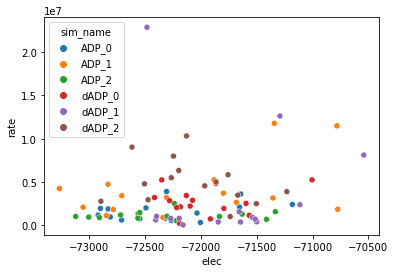

In [84]:
sns.scatterplot(data = full_binding_elec_data, x = 'elec',y = 'rate', 
               hue = 'sim_name')

In [85]:

for index, row in full_binding_elec_data.iterrows():
    print(row)

sim_name               ADP_0
sample_num                 1
rate          1935135.760556
Frame                      1
elec             -72899.4081
sim_name_2             ADP_0
Name: 0, dtype: object
sim_name               ADP_0
sample_num                 2
rate          1991751.173036
Frame                      2
elec             -72491.0588
sim_name_2             ADP_0
Name: 1, dtype: object
sim_name               ADP_0
sample_num                 3
rate          3883180.484272
Frame                      3
elec             -72306.4264
sim_name_2             ADP_0
Name: 2, dtype: object
sim_name             ADP_0
sample_num               4
rate          946368.34368
Frame                    4
elec             -72810.74
sim_name_2           ADP_0
Name: 3, dtype: object
sim_name               ADP_0
sample_num                 5
rate          2394210.460886
Frame                      5
elec             -71180.9421
sim_name_2             ADP_0
Name: 4, dtype: object
sim_name              ADP_0

In [86]:
np.unique(full_binding_elec_data.sim_name)

array(['ADP_0', 'ADP_1', 'ADP_2', 'dADP_0', 'dADP_1', 'dADP_2'],
      dtype=object)

In [87]:
for bd_instance in [ADP_2,]:
    full_binding_elec_data[bd_instance.sim_name == full_binding_elec_data.sim_name]


In [88]:
full_binding_elec_data['pairs'] = 0
for index, row in full_binding_elec_data.iterrows():
    for sim in [ADP_0, ADP_1, ADP_2, dADP_0, dADP_1, dADP_2]:
        if row.sim_name == sim.sim_name:
            counter = int(row.Frame) - 1
            num_pairs = len(sim.pair_list[counter])
            full_binding_elec_data.loc[index,'pairs'] = num_pairs
        

In [89]:
full_binding_elec_data

,sim_name,sample_num,rate,Frame,elec,sim_name_2,pairs
0,ADP_0,1,1.935136e+06,1,-72899.4081,ADP_0,54
1,ADP_0,2,1.991751e+06,2,-72491.0588,ADP_0,57
2,ADP_0,3,3.883180e+06,3,-72306.4264,ADP_0,49
3,ADP_0,4,9.463683e+05,4,-72810.7400,ADP_0,25
4,ADP_0,5,2.394210e+06,5,-71180.9421,ADP_0,41
...,...,...,...,...,...,...,...
85,dADP_2,11,5.483106e+06,11,-72264.5753,dADP_2,43
86,dADP_2,12,4.775002e+06,12,-72504.3722,dADP_2,62
87,dADP_2,13,9.023730e+06,13,-72616.3382,dADP_2,47
88,dADP_2,14,4.998381e+06,14,-71864.2705,dADP_2,32


<AxesSubplot:xlabel='pairs', ylabel='rate'>

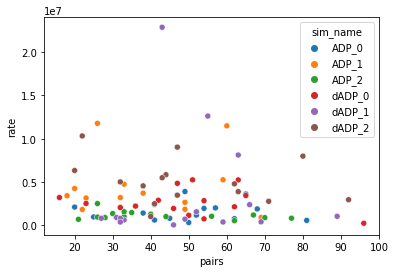

In [90]:
sns.scatterplot(data = full_binding_elec_data, x = 'pairs',y = 'rate', 
               hue = 'sim_name')

In [91]:
from scipy.stats import pearsonr

In [92]:
pearsonr(full_binding_elec_data.pairs, full_binding_elec_data.rate)

(-0.05009136983421773, 0.6391695020485331)

In [94]:
np.corrcoef(full_binding_elec_data.elec, full_binding_elec_data.rate)

array([[1.        , 0.16697651],
       [0.16697651, 1.        ]])

## Load in the apbs results 

In [95]:
fname = '/home/marcus/Documents/myosin_dynamics/1qvi_MSM/apbs_calc_and_vis/apbs_solvation_energies/data/myosin_adp_1_c15.log'
def read_apbs_log(file_name):
    f = open(fname)
    lines = f.readlines()
    f.close()
    for line in lines:
        # coulombic_energy 
        if 'Total energy = ' in line:
            coulombic_energy  = (float(line.split(' = ')[1].split(' kJ')[0]))
            #print(coulombic_energy)
        # nonpolar energy 
        
        elif 'Total non-polar energy = ' in line:
            nonpolar = (float(line.split(' = ')[1].split(' kJ')[0]))
            #print(nonpolar)
        
        # electrostatic
        elif '  Global net ELEC energy = ' in line: 
            electrostatic = (float(line.split(' = ')[1].split(' kJ')[0]))
            #print(electrostatic)
    return coulombic_energy, nonpolar, electrostatic

read_apbs_log(fname)

(-1228572.375278, 4749.866975246, -9769.834501544)

In [96]:
eps = 4

data_path = '/home/marcus/Documents/myosin_dynamics/1qvi_MSM/apbs_calc_and_vis/apbs_solvation_energies/data/'

full_binding_elec_data['coulomb'] = 0.0
full_binding_elec_data['nonpolar'] = 0.0
full_binding_elec_data['elec_apbs'] = 0.0
full_binding_elec_data['solv_free'] = 0.0


for index, row in full_binding_elec_data.iterrows():
    nuc = row.sim_name.split('_')[0].lower()
    meta = row.sim_name.split('_')[1]
    frame = row.Frame
    fname = data_path + 'myosin_{}_{}_c{}.log'.format(nuc, meta, frame)
    # print(fname)
    electrostatic_data = read_apbs_log(fname) # format (coulombic_energy, nonpolar, electrostatic)
    full_binding_elec_data.loc[index, 'coulomb'] = electrostatic_data[0]
    full_binding_elec_data.loc[index, 'nonpolar'] = electrostatic_data[1]
    full_binding_elec_data.loc[index, 'elec_apbs'] = electrostatic_data[2]
    
full_binding_elec_data['solv_free'] = full_binding_elec_data.elec_apbs + full_binding_elec_data.nonpolar + 1/eps * full_binding_elec_data.coulomb

<AxesSubplot:xlabel='solv_free', ylabel='rate'>

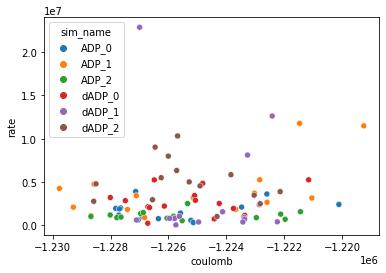

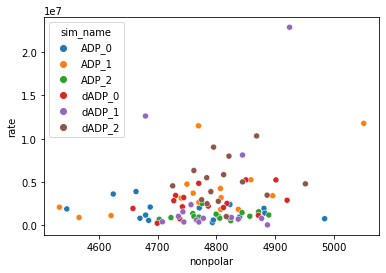

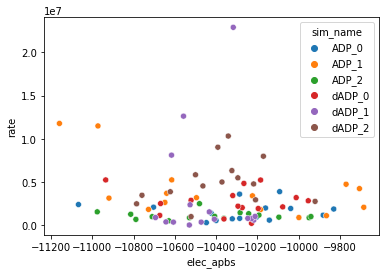

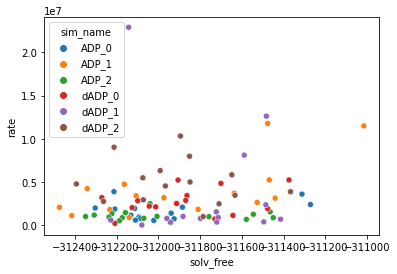

In [97]:
plt.figure()
sns.scatterplot(data = full_binding_elec_data,
         x = 'coulomb',
         y = 'rate',
         hue = 'sim_name')

plt.figure()
sns.scatterplot(data = full_binding_elec_data,
         x = 'nonpolar',
         y = 'rate',
         hue = 'sim_name')

plt.figure()
sns.scatterplot(data = full_binding_elec_data,
         x = 'elec_apbs',
         y = 'rate',
         hue = 'sim_name')


plt.figure()
sns.scatterplot(data = full_binding_elec_data,
         x = 'solv_free',
         y = 'rate',
         hue = 'sim_name')



<AxesSubplot:xlabel='solv_free', ylabel='rate'>

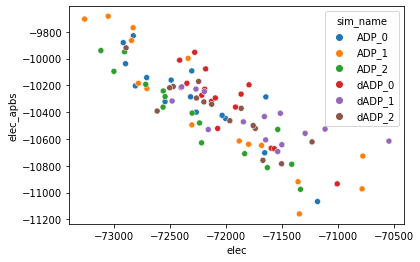

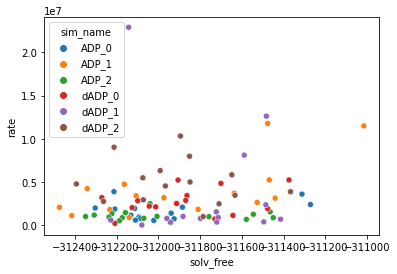

In [98]:
plt.figure()
sns.scatterplot(data = full_binding_elec_data,
         x = 'elec',
         y = 'elec_apbs',
         hue = 'sim_name')


plt.figure()
sns.scatterplot(data = full_binding_elec_data,
         x = 'solv_free',
         y = 'rate',
         hue = 'sim_name')

In [99]:
full_binding_elec_data['nucl']=full_binding_elec_data.sim_name.str.split('_',expand=True)[0]
full_binding_elec_data['meta_n']=full_binding_elec_data.sim_name.str.split('_',expand=True)[1]

In [100]:
full_binding_elec_data

,sim_name,sample_num,rate,Frame,elec,sim_name_2,pairs,coulomb,nonpolar,elec_apbs,solv_free,nucl,meta_n
0,ADP_0,1,1.935136e+06,1,-72899.4081,ADP_0,54,-1.227823e+06,4881.045312,-10038.298517,-312112.938253,ADP,0
1,ADP_0,2,1.991751e+06,2,-72491.0588,ADP_0,57,-1.227652e+06,4770.948726,-10160.477752,-312302.506628,ADP,0
2,ADP_0,3,3.883180e+06,3,-72306.4264,ADP_0,49,-1.227135e+06,4663.161440,-10091.935922,-312212.445929,ADP,0
3,ADP_0,4,9.463683e+05,4,-72810.7400,ADP_0,25,-1.226914e+06,4839.554250,-10203.886971,-312092.825448,ADP,0
4,ADP_0,5,2.394210e+06,5,-71180.9421,ADP_0,41,-1.220110e+06,4823.084585,-11067.227167,-311271.571251,ADP,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,dADP_2,11,5.483106e+06,11,-72264.5753,dADP_2,43,-1.226253e+06,4783.578063,-10294.432940,-312074.022902,dADP,2
86,dADP_2,12,4.775002e+06,12,-72504.3722,dADP_2,62,-1.228505e+06,4951.607217,-10218.037488,-312392.740125,dADP,2
87,dADP_2,13,9.023730e+06,13,-72616.3382,dADP_2,47,-1.226463e+06,4795.203534,-10391.419411,-312211.998671,dADP,2
88,dADP_2,14,4.998381e+06,14,-71864.2705,dADP_2,32,-1.225284e+06,4844.622989,-10371.499993,-311847.966517,dADP,2


In [101]:
from PIL import Image

img = np.asarray(Image.open('/home/marcus/Documents/myosin_dynamics/1qvi_MSM/bd_adp/prep_files/metastable_1/vmdscene_metastable_10.tga'))

In [104]:
i = 1
for index, row in full_binding_elec_data[full_binding_elec_data.nucl == 'ADP'].sort_values(by='rate', ascending=False).iterrows():
    print(row.sim_name, row.Frame,i)
    i+=1
    if i>10:
        break
        
i=1
print("\nLowest:")
for index, row in full_binding_elec_data[full_binding_elec_data.nucl == 'ADP'].sort_values(by='rate', ascending=True).iterrows():
    print(row.sim_name, row.Frame,i)
    i+=1
    if i>10:
        break

ADP_1 10 1
ADP_1 3 2
ADP_1 6 3
ADP_1 15 4
ADP_1 7 5
ADP_0 3 6
ADP_1 12 7
ADP_0 9 8
ADP_1 2 9
ADP_1 5 10

Lowest:
ADP_0 11 1
ADP_2 5 2
ADP_0 6 3
ADP_0 14 4
ADP_2 8 5
ADP_0 10 6
ADP_0 7 7
ADP_2 6 8
ADP_2 11 9
ADP_2 1 10


### SASA of binding atoms 

- Look at first all the binding solvent atoms solvent accessible surface area and total SASA

- Then look at all the individual atoms that may be correlated with binding rate 


In [105]:
def get_total_SASA(binding_reaction_atoms_set, fname):
    # Note log file atoms are 0 indexed, and 
    # Binding pair atoms are 1 indexed 
    f = open(fname)
    lines = f.readlines()
    f.close()
    SASA_list = []
    for line in lines:
        # coulombic_energy 
        if 'SASA for atom ' in line:
            SASA_list.append(float(line.split()[-1]))
    cumulative_SASA = 0
    for i in range(len(SASA_list)):
        if i+1 in binding_reaction_atoms_set:
            cumulative_SASA += SASA_list[i]
    
    return cumulative_SASA
    
atom_set = ADP_0.complete_pairs.myosin.unique()
for i in range(1,16):
    input_fname = '/home/marcus/Documents/myosin_dynamics/1qvi_MSM/apbs_calc_and_vis/apbs_solvation_energies/data/myosin_adp_0_c{}.log'.format(i)

    print(get_total_SASA(atom_set, input_fname))

1153.7278182291604
1077.362678842827
1061.8920478052362
1110.5134223975424
994.86667819446
1109.9520664508314
1157.3666299206293
1049.6893102436834
1115.0377933339944
1078.3311221952447
1201.841448153391
1066.1507346666367
1046.1409280633172
1060.1119317189805
1129.3533414052795


In [106]:
tqdm

tqdm.std.tqdm

In [107]:
full_binding_elec_data['SASA_pairs'] = 0.0

for index, row in tqdm(full_binding_elec_data.iterrows()):
    nuc = row.sim_name.split('_')[0].lower()
    meta = row.sim_name.split('_')[1]
    frame = row.Frame
    fname = data_path + 'myosin_{}_{}_c{}.log'.format(nuc, meta, frame)
    # print(fname)
    for sim in [ADP_0, ADP_1, ADP_2, dADP_0, dADP_1, dADP_2]:
        if sim.sim_name == sim.sim_name:
            atom_set = sim.complete_pairs.myosin.unique()
            full_binding_elec_data.loc[index, 'SASA_pairs'] = get_total_SASA(atom_set, fname)
            
    

90it [00:12,  7.13it/s]


<AxesSubplot:xlabel='sim_name', ylabel='SASA_pairs'>

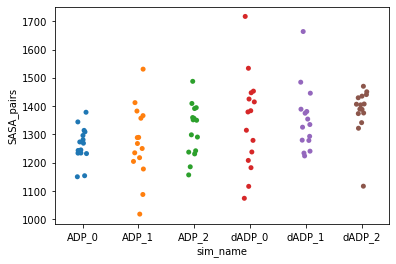

In [108]:
sns.stripplot(data = full_binding_elec_data,
         x = 'sim_name',
         y = 'SASA_pairs')

<AxesSubplot:xlabel='SASA_pairs', ylabel='rate'>

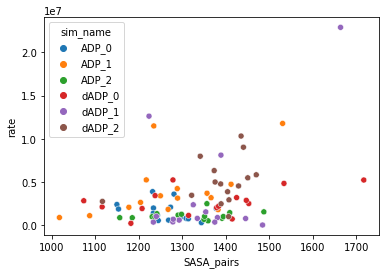

In [109]:
plt.figure()
sns.scatterplot(data = full_binding_elec_data,
         x = 'SASA_pairs',
         y = 'rate',
         hue = 'sim_name')


In [110]:
SASA_exploration_df = full_binding_elec_data[['sim_name','Frame','rate']].copy(deep=True)

SASA_exploration_df = pd.concat((SASA_exploration_df, pd.DataFrame(np.zeros((90, 15329)), columns = np.arange(1, 15329+1))),axis = 1)

SASA_exploration_df

,sim_name,Frame,rate,1,2,3,4,5,6,7,...,15320,15321,15322,15323,15324,15325,15326,15327,15328,15329
0,ADP_0,1,1.935136e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ADP_0,2,1.991751e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ADP_0,3,3.883180e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ADP_0,4,9.463683e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ADP_0,5,2.394210e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,dADP_2,11,5.483106e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,dADP_2,12,4.775002e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,dADP_2,13,9.023730e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,dADP_2,14,4.998381e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
SASA_exploration_df

def get_vector_SASA(fname):
    f = open(fname)
    lines = f.readlines()
    f.close()
    SASA_list = []
    for line in lines:
        # coulombic_energy 
        if 'SASA for atom ' in line:
            SASA_list.append(float(line.split()[-1]))
            
    return np.array(SASA_list)

In [112]:
get_vector_SASA(fname).shape

(15329,)

In [113]:
for index, row in tqdm(SASA_exploration_df.iterrows()):
    nuc = row.sim_name.split('_')[0].lower()
    meta = row.sim_name.split('_')[1]
    frame = row.Frame
    fname = data_path + 'myosin_{}_{}_c{}.log'.format(nuc, meta, frame)
    # print(fname)
    for sim in [ADP_0, ADP_1, ADP_2, dADP_0, dADP_1, dADP_2]:
        if sim.sim_name == sim.sim_name:
            atom_set = sim.complete_pairs.myosin.unique()

            SASA_exploration_df.iloc[index, 3:] = get_vector_SASA(fname)

90it [01:21,  1.10it/s]


In [117]:
SASA_exploration_df

,sim_name,Frame,rate,1,2,3,4,5,6,7,...,15320,15321,15322,15323,15324,15325,15326,15327,15328,15329
0,ADP_0,1,1.935136e+06,32.725101,0.0,0.0,0.0,2.237181,5.494380,0.000000,...,13.124798,13.075772,11.712825,38.958453,0.0,0.0,0.0,2.535472,1.851713,0.702374
1,ADP_0,2,1.991751e+06,43.208466,0.0,0.0,0.0,0.298291,9.370260,0.000000,...,15.958561,10.605431,13.501693,58.437679,0.0,0.0,0.0,1.267736,11.046424,26.179386
2,ADP_0,3,3.883180e+06,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,16.704288,13.672061,1.916644,59.429349,0.0,0.0,0.0,4.101499,43.483322,11.557241
3,ADP_0,4,9.463683e+05,3.683345,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,14.541679,9.753589,11.712825,64.883533,0.0,0.0,0.0,1.715172,40.801531,42.078575
4,ADP_0,5,2.394210e+06,53.975166,0.0,0.0,0.0,0.671154,4.599946,0.298291,...,5.443808,0.553697,12.990588,51.070990,0.0,0.0,0.0,3.430345,46.356670,4.405799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,dADP_2,11,5.483106e+06,55.958505,0.0,0.0,0.0,0.596582,2.811078,0.149145,...,13.199370,11.585049,8.859155,63.112694,0.0,0.0,0.0,4.176072,43.227914,36.651141
86,dADP_2,12,4.775002e+06,6.445853,0.0,0.0,0.0,2.311754,10.988760,0.447436,...,0.745727,7.922129,0.000000,18.133389,0.0,0.0,0.0,1.640600,0.319261,12.515024
87,dADP_2,13,9.023730e+06,6.162519,0.0,0.0,0.0,0.000000,0.042592,0.000000,...,9.247017,2.172197,9.029523,60.775187,0.0,0.0,0.0,6.264108,43.291766,39.141375
88,dADP_2,14,4.998381e+06,3.116676,0.0,0.0,0.0,0.149145,5.962893,0.000000,...,15.883988,12.990588,5.579564,37.966783,0.0,0.0,0.0,3.430345,19.666466,2.490234


In [118]:
SASA_exploration_df[1]

0     32.725101
1     43.208466
2      0.000000
3      3.683345
4     53.975166
        ...    
85    55.958505
86     6.445853
87     6.162519
88     3.116676
89    53.125163
Name: 1, Length: 90, dtype: float64

In [119]:
stats.pearsonr(SASA_exploration_df.rate, SASA_exploration_df[i+1])

(-0.06360180895118844, 0.55147664560496)

In [120]:
correlation_array = np.zeros(15329)
p_val_pear_array = np.zeros(15329)

for i in np.arange(15329):
# for i in range(10):
    pear_r, p_val_pear = stats.pearsonr(SASA_exploration_df[i+1], SASA_exploration_df.rate)
    correlation_array[i] = pear_r
    p_val_pear_array[i] = p_val_pear

/home/marcus/anaconda3/envs/pyemma/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [121]:
np.argsort(p_val_pear_array)

array([  765,  5714,  4111, ...,  8736, 12335,  2668])

(0.665379829510747, 8.441004226762926e-13)
(0.6526143290457149, 3.18270292385031e-12)
(0.6477922155748034, 5.1695202516464595e-12)
(0.624171321834313, 4.934630677117273e-11)
(0.6207543977417774, 6.733125451454611e-11)
(0.6207543977417774, 6.733125451454611e-11)
(0.6207543977417774, 6.733125451454611e-11)
(0.6207543977417774, 6.733125451454611e-11)
(0.6207543977417774, 6.733125451454611e-11)
(0.6202530512035014, 7.045009513421791e-11)
(0.619316159954288, 7.665435887046618e-11)
(0.6041867664551833, 2.884389082763104e-10)
(0.5793478594297604, 2.1982594206246935e-09)
(0.5665374098923639, 5.87247253158269e-09)
(0.5627321541837759, 7.800292635712075e-09)
(0.5601432677312567, 9.442923388526399e-09)
(0.5581301355752942, 1.0943476126726416e-08)
(0.557168431706403, 1.173822866696655e-08)
(0.5438118965576273, 3.0385972564448405e-08)
(0.533681573798889, 6.08386346277319e-08)


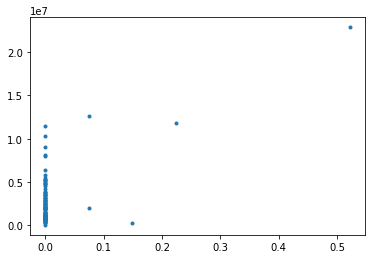

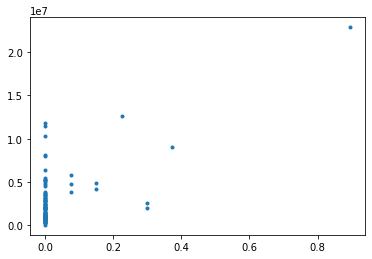

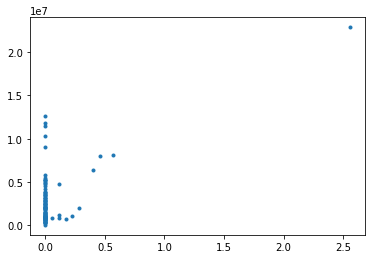

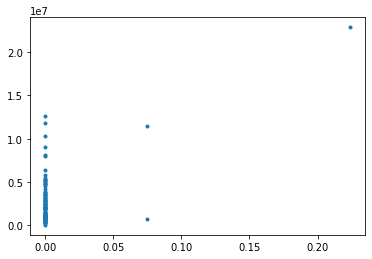

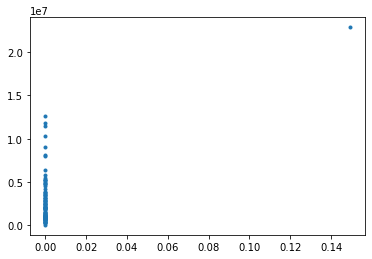

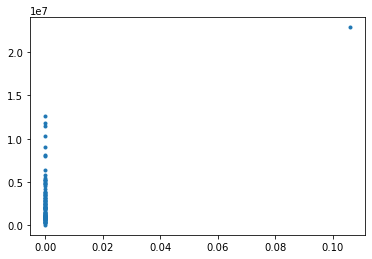

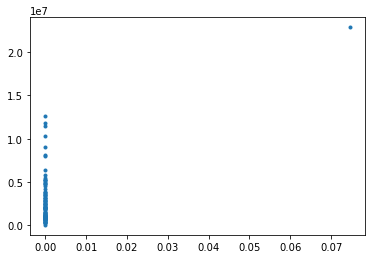

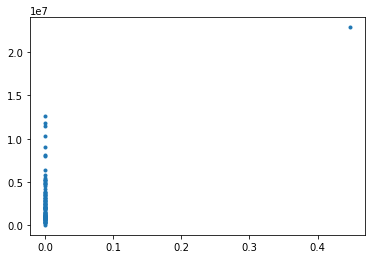

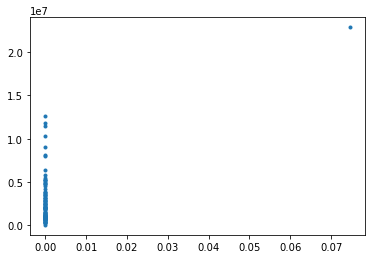

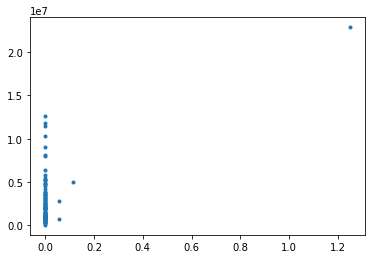

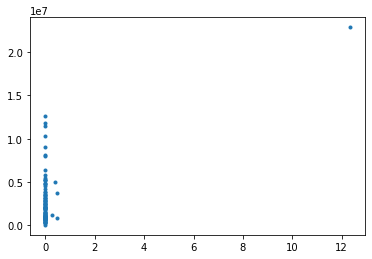

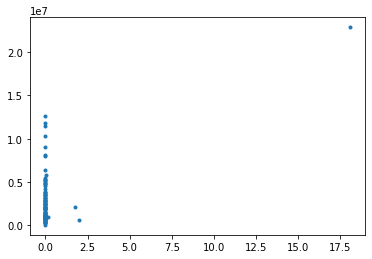

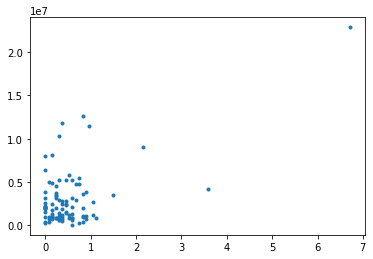

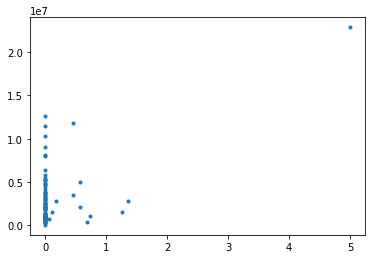

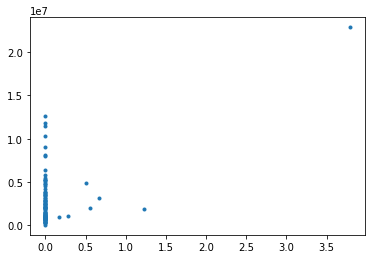

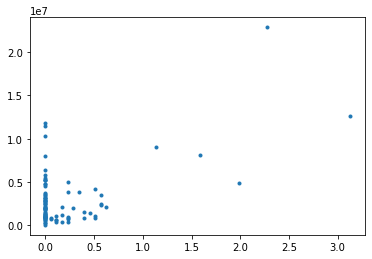

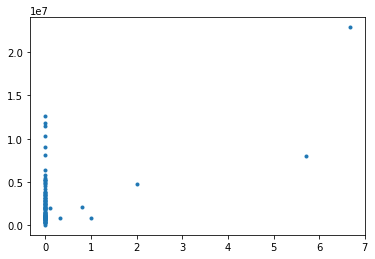

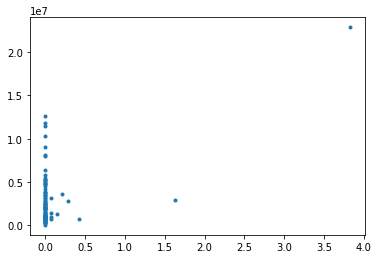

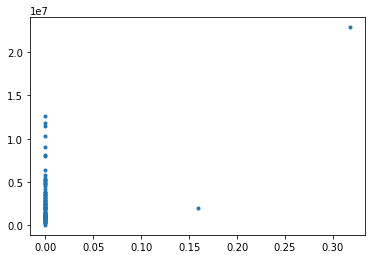

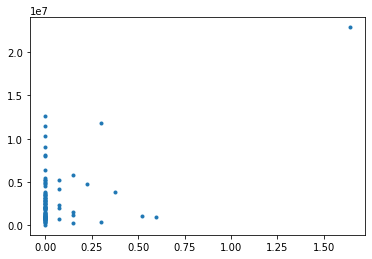

In [122]:
for index in np.argsort(p_val_pear_array)[0:20]:
    print(stats.pearsonr(SASA_exploration_df[index+1], SASA_exploration_df['rate']))
    plt.figure()
    plt.plot(SASA_exploration_df[index+1], SASA_exploration_df['rate'],'.')

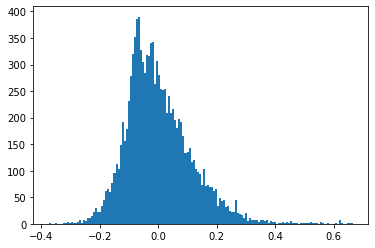

In [123]:
plt.hist(correlation_array, bins = 150)
plt.show()

In [124]:
spearman_r_array = np.zeros(15329)
p_val_spearman_array = np.zeros(15329)

for i in np.arange(15329):
# for i in range(10):
    spearman_r, p_val_spearman = stats.spearmanr(SASA_exploration_df[i+1], SASA_exploration_df.rate)
    spearman_r_array[i] = spearman_r
    p_val_spearman_array[i] = p_val_spearman

/home/marcus/anaconda3/envs/pyemma/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


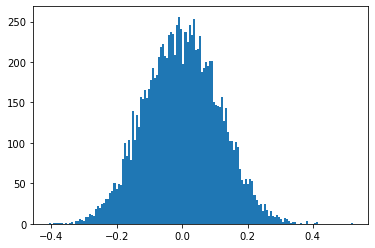

In [125]:
plt.hist(spearman_r_array, bins = 150)
plt.show()

(0.49280885121989254, 8.046003618424011e-07)
(0.3996121593922399, 9.542499279465936e-05)
(0.3489436317516384, 0.000749762632257903)
(0.42488262853271425, 2.9926909819612777e-05)
(0.3604627220793344, 0.00048311480748572426)
(0.26961322410721766, 0.010175789563998604)
(0.6526143290457149, 3.18270292385031e-12)
(0.31561375314994217, 0.00244414340126393)
(0.2893757483684777, 0.005669037790388542)
(0.24616911794847002, 0.019343992499468395)
(0.35566175121180443, 0.0005813993843363991)
(0.17025135342382222, 0.10864684393397969)
(0.19913540260370557, 0.05988370378703287)
(0.4517088510040955, 7.864014725265603e-06)
(0.24534039354078946, 0.019768615525990848)
(0.07175469209838561, 0.5015350747252301)
(0.16064777827433016, 0.13038700849212556)
(0.1000791093717995, 0.34797665256437066)
(0.12943772896861602, 0.22401850798395784)
(0.30257127304386, 0.0037484738613126154)


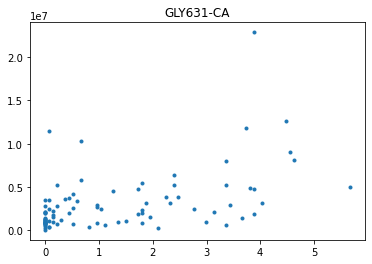

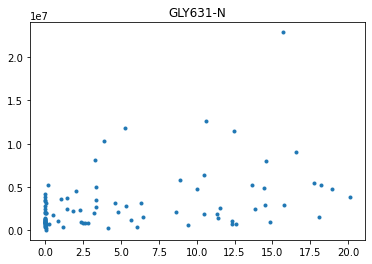

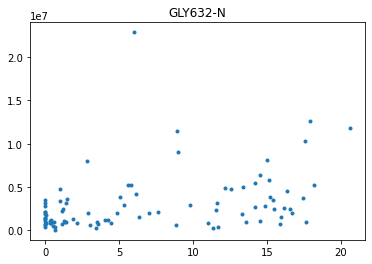

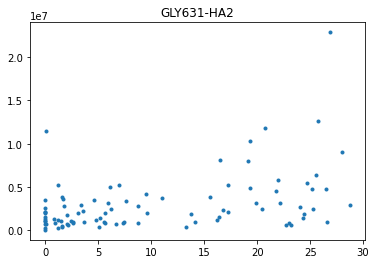

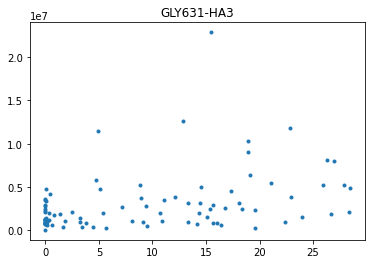

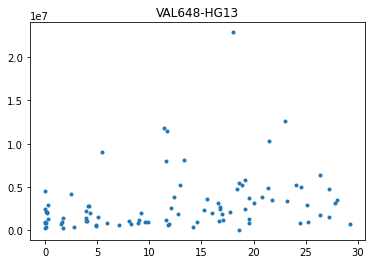

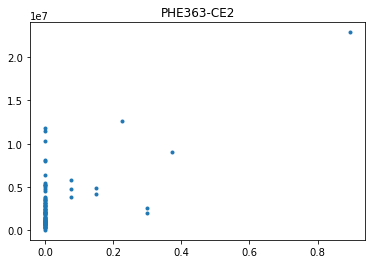

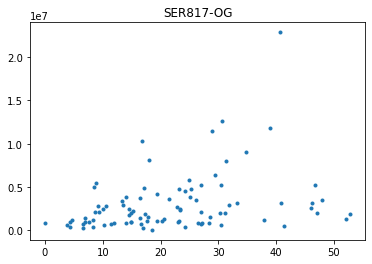

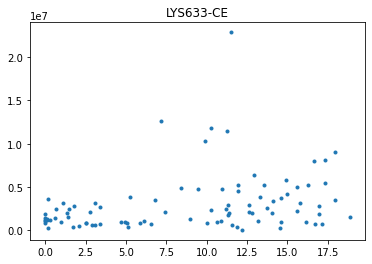

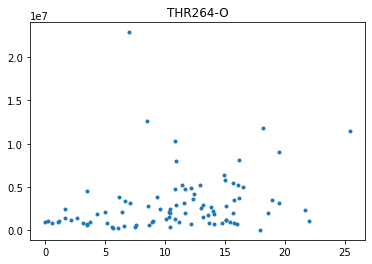

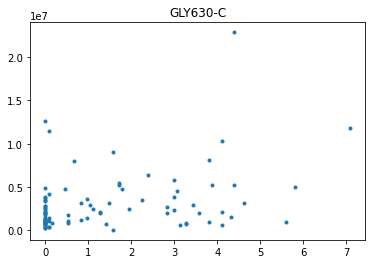

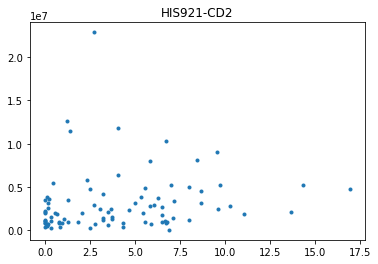

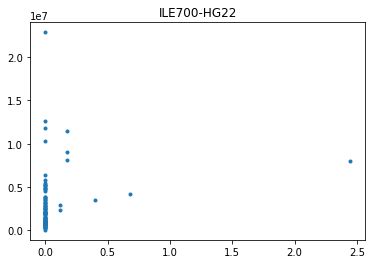

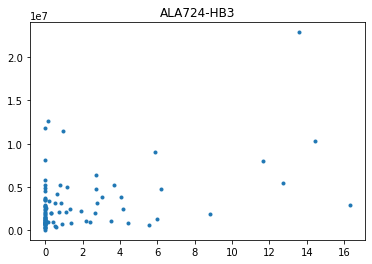

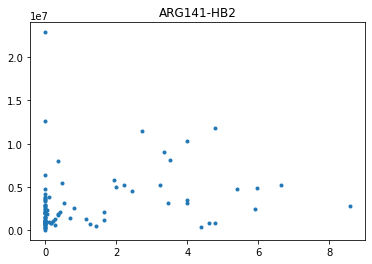

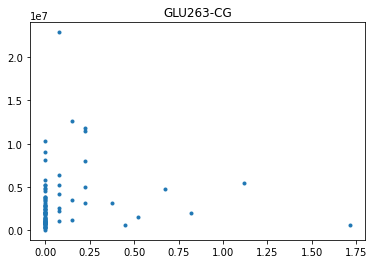

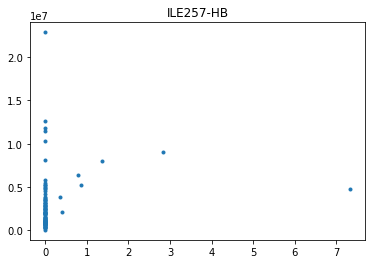

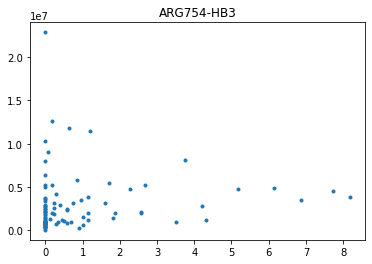

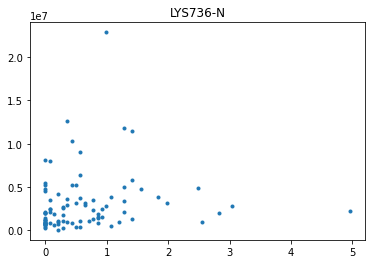

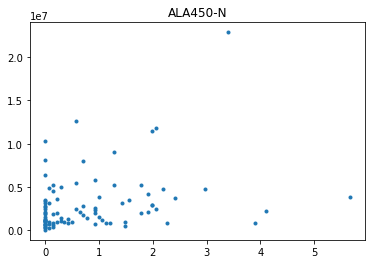

In [126]:
for index in (np.argsort(spearman_r_array*-1))[0:20]:
    print(stats.pearsonr(SASA_exploration_df[index+1], SASA_exploration_df['rate']))
    plt.figure()
    plt.title(str(ADP_0.pdb_list[0].top.atom(index)))
    plt.plot(SASA_exploration_df[index+1], SASA_exploration_df['rate'],'.')

In [ ]:
### Write function to take the SASA from the atoms and 


In [127]:
residue_list = []
for res in ADP_0.pdb_list[0].top.residues:
    residue_list.append(res.name +'-'+ str(res.resSeq))

SASA_residue_df = pd.DataFrame(np.zeros((90, len(residue_list))), columns = residue_list)

for col_ind in range(len(residue_list)):
    
    temp_array = np.zeros(90)
    
    for atom in ADP_0.pdb_list[0].top.residue(col_ind).atoms:
        temp_array += SASA_exploration_df[atom.index+1]    
    SASA_residue_df.iloc[:,col_ind] = temp_array


In [128]:
spearman_list = []
for res in SASA_residue_df.columns:
    spearman_list.append(stats.kendalltau(SASA_residue_df[res], np.log(SASA_exploration_df.rate)))

In [129]:
spearman_list[arg][1]

NameError: name 'arg' is not defined

In [130]:
residue_list[0]

'MET-1'

GLY-631, VAL-648, SER-640, LYS-763, GLY-632, LYS-633, GLU-627, SER-639, GLN-643, GLY-630, 

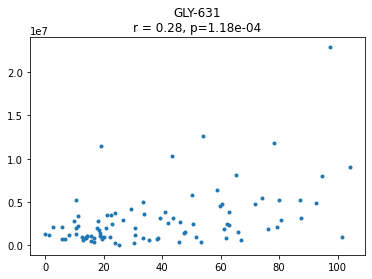

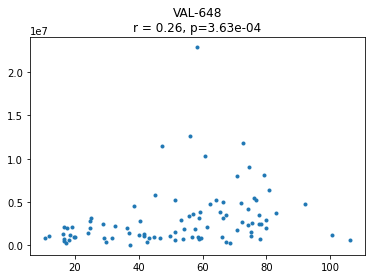

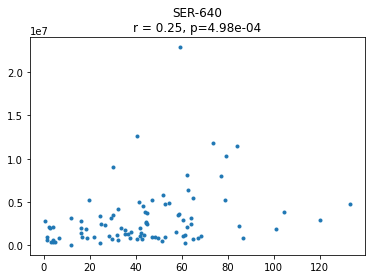

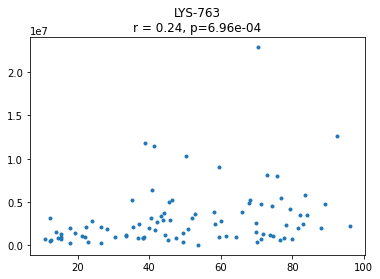

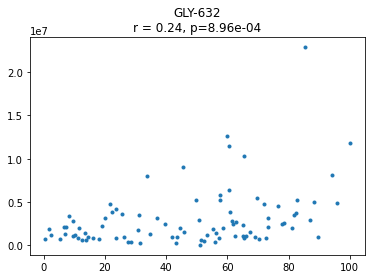

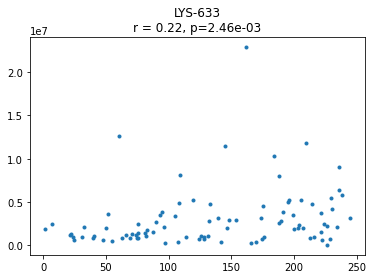

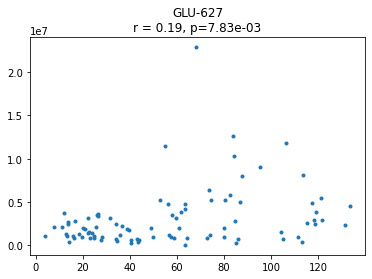

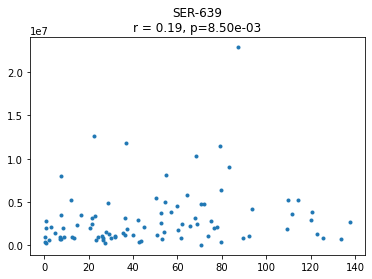

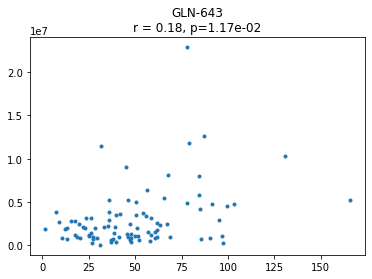

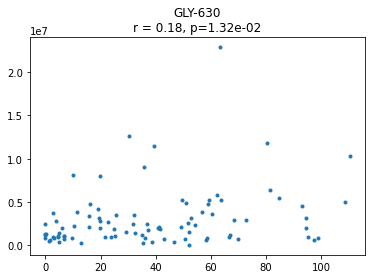

In [131]:


for arg in np.argsort(np.array(spearman_list)[:,1])[0:20]:
    if spearman_list[arg][0]> 0:
        plt.figure()
        #print()
        #plt.title(np.array(spearman_list)[arg, 1])
        plt.title('{}\nr = {:.2f}, p={:.2e}'.format(residue_list[arg], spearman_list[arg][0],np.array(spearman_list)[arg, 1]))
        #print(residue_list[arg].split('-')[1], end = ', ')
        print(residue_list[arg], end = ', ')
        plt.plot(SASA_residue_df.iloc[:,arg], (SASA_exploration_df.rate),'.')

In [559]:
from sklearn import linear_model
# https://www.w3schools.com/python/python_ml_multiple_regression.asp



In [538]:


from sklearn import linear_model


In [132]:
X = SASA_residue_df[["GLY-631", "VAL-648", "SER-640", "LYS-763", "GLY-632", "LYS-633", "GLU-627", "SER-639", "GLN-643", "GLY-630",]]
y = SASA_exploration_df.rate

In [133]:
regr = linear_model.LinearRegression()
regr.fit(X, y) 

np.array(["GLY-631", "VAL-648", "SER-640", "LYS-763", "GLY-632", "LYS-633", "GLU-627", "SER-639", "GLN-643", "GLY-630",])[np.argsort(regr.coef_)[::-1]]



NameError: name 'linear_model' is not defined

### tICA Correlation 

In [63]:
adp_samples_file = "../msm_datafiles/adp_sampled_frame_data.pkl"

try:
    f = open(adp_samples_file, 'rb')
    adp_samples = pickle.load(f)
    f.close()
    print("Loading samples from {}".format(adp_samples_file))
    print("Modified on:")
    modified = os.path.getctime(adp_samples_file)
    print(datetime.datetime.fromtimestamp(modified))
except:
    print('Could not load file. ')

Loading samples from ../msm_datafiles/adp_sampled_frame_data.pkl
Modified on:
2024-05-30 17:28:07.184958


In [64]:
dadp_samples_file = "../msm_datafiles/dadp_sampled_frame_data.pkl"

try:
    f = open(dadp_samples_file, 'rb')
    dadp_samples = pickle.load(f)
    f.close()
    print("Loading samples from {}".format(dadp_samples_file))
    print("Modified on:")
    modified = os.path.getctime(dadp_samples_file)
    print(datetime.datetime.fromtimestamp(modified))
except:
    print('Could not load file. ')

Loading samples from ../msm_datafiles/dadp_sampled_frame_data.pkl
Modified on:
2024-05-30 17:28:10.793042


In [65]:
f = open('../msm_datafiles/all_loop_COMs_adp.pkl','rb')
ADP_COMS_output = pickle.load(f)
f.close()

f = open('../msm_datafiles/all_loop_COMs_dadp.pkl','rb')
dADP_COMS_output = pickle.load(f)
f.close()

In [66]:
ADP_dADP_COMs_output = [ADP_COMS_output[0],
                        ADP_COMS_output[1],
                        ADP_COMS_output[2],
                        dADP_COMS_output[0],
                        dADP_COMS_output[1],
                        dADP_COMS_output[2]]

In [67]:
inter_region_distances = []
for data_chunk in ADP_dADP_COMs_output:
    new_chunk = []
    for i in range(7):
        for j in range(i+1,7):
            x = np.linalg.norm(data_chunk[:,i*3:i*3+3] - data_chunk[:,j*3:j*3+3], axis = 1)
            new_chunk.append(x)
            
    new_chunk.append(data_chunk[:,21])
    new_chunk.append(data_chunk[:,22])
    new_chunk = np.array(new_chunk).reshape(-1,200000).T
    inter_region_distances.append(new_chunk)

In [68]:
name_list = ['CM_tip', 'CM_base', 'loop_4_tip', 'loop_4_base', 'loop_2_all', 'loop_2_tip', 'strut_COM']
measure_name_list = []
for i in range(7):
    for j in range(i+1,7):
        print('COM {} - {}'.format(name_list[i],name_list[j]))
        measure_name_list.append('COM {} - {}'.format(name_list[i],name_list[j]))
        
measure_name_list.append('DIST: GLN370 CA - LYS540 CA')
measure_name_list.append('DIST: GLY405 CA - LYS540 CA')

COM CM_tip - CM_base
COM CM_tip - loop_4_tip
COM CM_tip - loop_4_base
COM CM_tip - loop_2_all
COM CM_tip - loop_2_tip
COM CM_tip - strut_COM
COM CM_base - loop_4_tip
COM CM_base - loop_4_base
COM CM_base - loop_2_all
COM CM_base - loop_2_tip
COM CM_base - strut_COM
COM loop_4_tip - loop_4_base
COM loop_4_tip - loop_2_all
COM loop_4_tip - loop_2_tip
COM loop_4_tip - strut_COM
COM loop_4_base - loop_2_all
COM loop_4_base - loop_2_tip
COM loop_4_base - strut_COM
COM loop_2_all - loop_2_tip
COM loop_2_all - strut_COM
COM loop_2_tip - strut_COM


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Feature values', ylabel='Feature histograms'>)

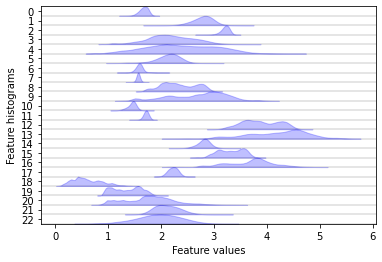

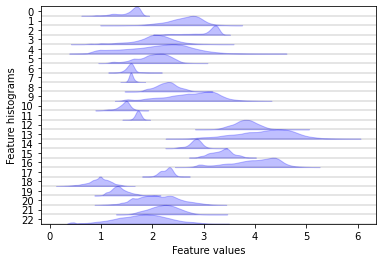

In [69]:
pyemma.plots.plot_feature_histograms(np.concatenate(inter_region_distances[0:3]))
pyemma.plots.plot_feature_histograms(np.concatenate(inter_region_distances[3:6]))

calculate covariances:   0%|                                              | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_66796/1831271406.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


'\nfig, ax = plt.subplots(6,1,figsize = (6,7))\nfor i in range(6):\n    \n    pyemma.plots.plot_feature_histograms(tica_output[i], ax= ax[i])\n    ax[i].set_title(i)'

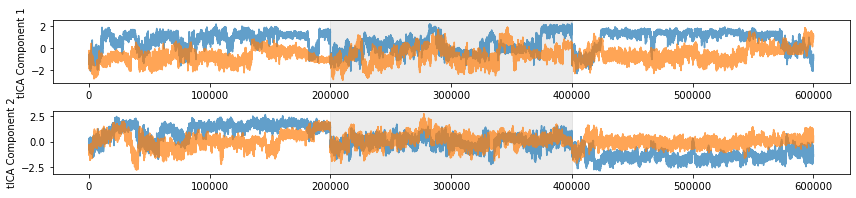

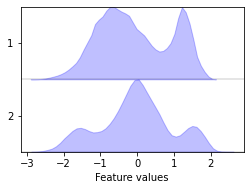

In [578]:
n_dim = 2
tica = pyemma.coordinates.tica(inter_region_distances, dim = n_dim, lag = 20)
tica_output = tica.transform(inter_region_distances)

fig, ax = plt.subplots(n_dim,1,figsize = (12,8/6*n_dim))
for i in range(n_dim):
    ax[i].plot(np.concatenate(tica_output)[0:600000,i], alpha = 0.7)
    ax[i].plot(np.concatenate(tica_output)[600000:1200000,i], alpha = 0.7)
    ax[i].axvspan(200000,400000, color = 'gray',alpha = 0.15)
    ax[i].set_ylabel("tICA Component {}".format(i+1))
#plt.axvspan(600000,800000, color = 'gray',alpha = 0.15)
#plt.axvspan(1000000,1200000, color = 'gray',alpha = 0.15)
plt.tight_layout()
fig.show()


fig, ax = plt.subplots(1,1,figsize = (4, 8/6*n_dim))
pyemma.plots.plot_feature_histograms(np.concatenate(tica_output), ax = ax, feature_labels = list(np.arange(1,n_dim+1)))

# Beyond 5 dim, the tICA components become pretty boring 
'''
fig, ax = plt.subplots(6,1,figsize = (6,7))
for i in range(6):
    
    pyemma.plots.plot_feature_histograms(tica_output[i], ax= ax[i])
    ax[i].set_title(i)'''



In [70]:

tica_output[0][0,0]

-1.3530731

In [582]:
np.concatenate((adp_tica_arrays, dadp_tica_arrays)).shape

(90, 2)

In [583]:
SASA_exploration_df['tica_0'] = np.concatenate((adp_tica_arrays, dadp_tica_arrays))[:,0]
SASA_exploration_df['tica_1'] = np.concatenate((adp_tica_arrays, dadp_tica_arrays))[:,1]

Pearson correlation coefficient: -0.38
P-value: 2.059e-04


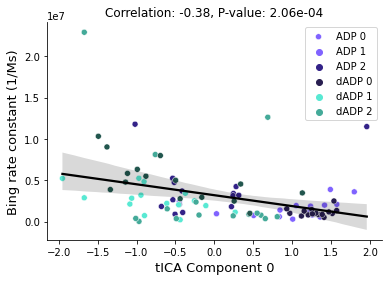

In [584]:
# Plotting the scatter plot
sns.scatterplot(data=SASA_exploration_df, 
                x='tica_0', 
                y='rate', 
                hue='sim_name', 
                palette=combined_colors)

# Add a regression line using regplot with the same DataFrame and x, y axes
# Set scatter=False to avoid duplicating points
sns.regplot(data=SASA_exploration_df, 
            x='tica_0', 
            y='rate', 
            scatter=False, 
            line_kws={'color': 'black'})  # Customize the color of the line

# Calculate the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(SASA_exploration_df['tica_0'], SASA_exploration_df['rate'])
print("Pearson correlation coefficient: {:.2f}".format(correlation))
print("P-value: {:.3e}".format(p_value))

# Customize the legend for the scatterplot
plt.legend(['ADP 0','ADP 1','ADP 2','dADP 0','dADP 1','dADP 2'])
plt.title(f'Correlation: {correlation:.2f}, P-value: {p_value:.2e}')
plt.ylabel('Bing rate constant (1/Ms)', fontsize = 13)
plt.xlabel('tICA Component 0', fontsize = 13)
# Remove the top right borders 
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)

# Show the plot
# Show the plot
# plt.savefig('../figures/tica_0_rate_cor.png', dpi = 900)
plt.show()

Pearson correlation coefficient: -0.11
P-value: 3.196e-01


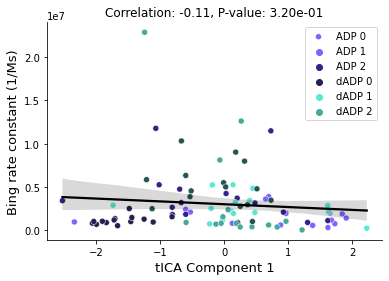

In [585]:
# Plotting the scatter plot
sns.scatterplot(data=SASA_exploration_df, 
                x='tica_1', 
                y='rate', 
                hue='sim_name', 
                palette=combined_colors)

# Add a regression line using regplot with the same DataFrame and x, y axes
# Set scatter=False to avoid duplicating points
sns.regplot(data=SASA_exploration_df, 
            x='tica_1', 
            y='rate', 
            scatter=False, 
            line_kws={'color': 'black'})  # Customize the color of the line

# Calculate the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(SASA_exploration_df['tica_1'], SASA_exploration_df['rate'])
print("Pearson correlation coefficient: {:.2f}".format(correlation))
print("P-value: {:.3e}".format(p_value))

# Customize the legend for the scatterplot
plt.legend(['ADP 0','ADP 1','ADP 2','dADP 0','dADP 1','dADP 2'])
plt.title(f'Correlation: {correlation:.2f}, P-value: {p_value:.2e}')
plt.ylabel('Bing rate constant (1/Ms)', fontsize = 13)
plt.xlabel('tICA Component 1', fontsize = 13)
# Remove the top right borders 
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
# Show the plot
# plt.savefig('../figures/tica_1_rate_cor.png', dpi = 900)
plt.show()


In [586]:
p_value

0.3196467905652197

In [591]:
formatted_list_name = ['Dist: CM loop tip - CM loop base',
 'Dist: CM loop tip - loop 4 tip',
 'Dist: CM loop tip - loop 4 base',
 'Dist: CM loop tip - loop 2 all',
 'Dist: CM loop tip - loop 2 tip',
 'Dist: CM loop tip - strut COM',
 'Dist: CM loop base - loop 4 tip',
 'Dist: CM loop base - loop 4 base',
 'Dist: CM loop base - loop 2 all',
 'Dist: CM loop base - loop 2 tip',
 'Dist: CM loop base - strut COM',
 'Dist: loop 4 tip - loop 4 base',
 'Dist: loop 4 tip - loop 2 all',
 'Dist: loop 4 tip - loop 2 tip',
 'Dist: loop 4 tip - strut COM',
 'Dist: loop 4 base - loop 2 all',
 'Dist: loop 4 base - loop 2 tip',
 'Dist: loop 4 base - strut COM',
 'Dist: loop 2 all - loop 2 tip',
 'Dist: loop 2 all - strut COM',
 'Dist: loop 2 tip - strut COM',
 'Dist: GLN370 CA - LYS540 CA',
 'Dist: GLY405 CA - LYS540 CA']

In [592]:
feature_df = pd.DataFrame(np.concatenate((adp_inter_region_distances, dadp_inter_region_distances)), 
            columns = formatted_list_name)

In [593]:
feature_df['rate'] = SASA_exploration_df['rate']
feature_df['sim_name'] = SASA_exploration_df['sim_name']

Pearson correlation coefficient: 0.21
P-value: 4.586e-02


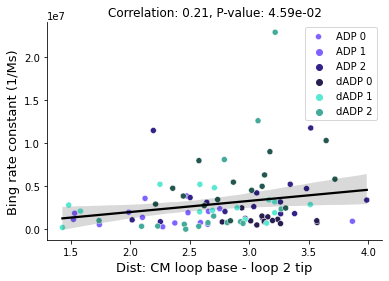

Pearson correlation coefficient: 0.38
P-value: 2.594e-04


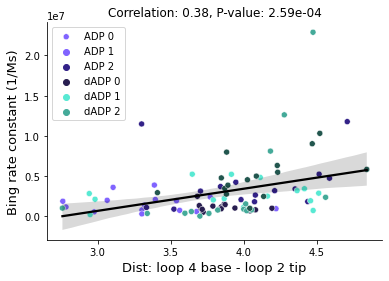

Pearson correlation coefficient: 0.38
P-value: 2.560e-04


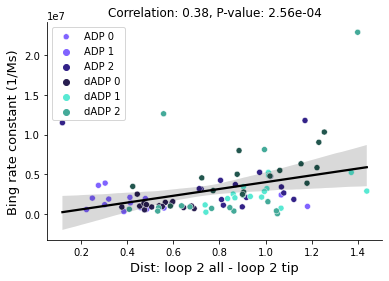

Pearson correlation coefficient: 0.42
P-value: 3.314e-05


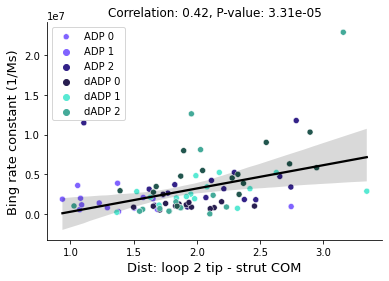

In [594]:
counter = 0
low_p_list = []
for feature in formatted_list_name:
    
    corr_r, p_val = stats.spearmanr(feature_df[feature], feature_df.rate)
    if p_val <= 0.05:
        plt.figure()
#         sns.scatterplot(data = feature_df,
#                        x = feature, 
#                        y = 'rate', 
#                        hue = 'sim_name', )
#                        #palette = 'jet')
#         plt.title('{:.2f} {:.2e} '.format(corr_r, p_val), color = 'red')
#         print(counter)
#         low_p_list.append(counter)
        
        sns.scatterplot(data=feature_df, 
                x=feature, 
                y='rate', 
                hue='sim_name', 
                palette=combined_colors)

        # Add a regression line using regplot with the same DataFrame and x, y axes
        # Set scatter=False to avoid duplicating points
        sns.regplot(data=feature_df, 
                    x=feature, 
                    y='rate', 
                    scatter=False, 
                    line_kws={'color': 'black'})  # Customize the color of the line

        # Calculate the Pearson correlation coefficient and p-value
        correlation, p_value = pearsonr(feature_df[feature], feature_df['rate'])
        print("Pearson correlation coefficient: {:.2f}".format(correlation))
        print("P-value: {:.3e}".format(p_value))

        # Customize the legend for the scatterplot
        plt.legend(['ADP 0','ADP 1','ADP 2','dADP 0','dADP 1','dADP 2'])
        plt.title(f'Correlation: {correlation:.2f}, P-value: {p_value:.2e}')
        plt.ylabel('Bing rate constant (1/Ms)', fontsize = 13)
        plt.xlabel(feature,fontsize = 13)
        # Remove the top right borders 
        ax = plt.gca()
        ax.spines[['right', 'top']].set_visible(False)


        # plt.savefig("../figures/feature_{}_corr.png".format(feature), dpi = 900)
    # else:
        # plt.title('{:.2f} {:.2e} '.format(corr_r, p_val), color = 'black')
    plt.show()
    counter +=1 

In [614]:
corr_list = []

for feature in formatted_list_name:
    
    corr_r, p_val = stats.spearmanr(feature_df[feature], feature_df.rate)
    corr_list.append((feature,corr_r, p_val))
    
corr_df = pd.DataFrame(corr_list, columns = ["Feature","Correlation", "P-value"])



In [52]:
alpha= 0.05
m = len(corr_df)
corr_df = corr_df.sort_values(by="P-value").reset_index(drop=True)

corr_df["Threshold"] = alpha / (m-corr_df.index.values)

corr_df["Significant"] = corr_df["P-value"] <= corr_df["Threshold"]
corr_df



,Feature,Correlation,P-value,Threshold,Significant
0,Dist: loop 2 all - loop 2 tip,0.431666,0.000022,0.002174,True
1,Dist: loop 4 base - loop 2 tip,0.429279,0.000024,0.002273,True
2,Dist: loop 2 tip - strut COM,0.401737,0.000087,0.002381,True
3,Dist: CM loop base - loop 2 tip,0.217829,0.039164,0.002500,False
4,Dist: loop 2 all - strut COM,0.204066,0.053702,0.002632,False
5,Dist: CM loop tip - loop 2 all,-0.167091,0.115467,0.002778,False
6,Dist: loop 4 tip - loop 2 tip,0.153772,0.147886,0.002941,False
7,Dist: CM loop base - loop 4 tip,-0.153607,0.148325,0.003125,False
8,Dist: loop 4 base - loop 2 all,0.146232,0.169041,0.003333,False
9,Dist: CM loop base - loop 4 base,0.127794,0.230008,0.003571,False


In [724]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.datasets import make_regression

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error




Mean Absolute Error: 3839163.906747173
Mean Absolute Error: 1594720.759696598
Mean Absolute Error: 1487951.1877323596
Mean Absolute Error: 1746946.2459991015
Mean Absolute Error: 2112310.235132589
Mean Absolute Error: 1322706.463919415
Mean Absolute Error: 1595925.6803753485
Mean Absolute Error: 1199284.39945445
Mean Absolute Error: 1644272.5711187106
Mean Absolute Error: 1485296.9269782428


/home/marcus/anaconda3/envs/pyemma/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.343e+12, tolerance: 9.779e+10
  model = cd_fast.enet_coordinate_descent(
/home/marcus/anaconda3/envs/pyemma/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.070e+12, tolerance: 1.011e+11
  model = cd_fast.enet_coordinate_descent(
/home/marcus/anaconda3/envs/pyemma/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

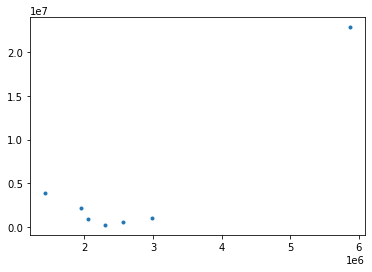

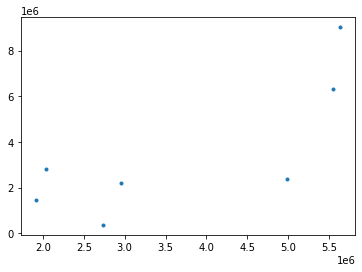

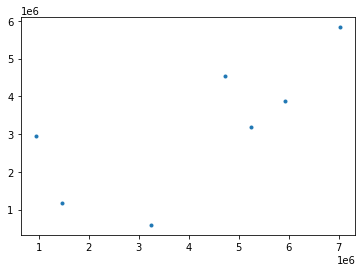

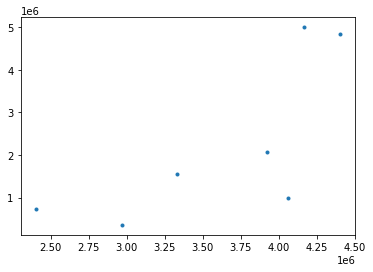

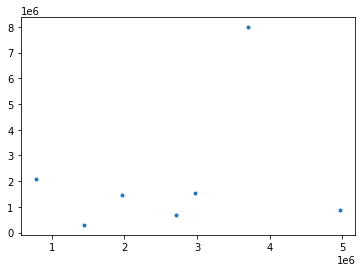

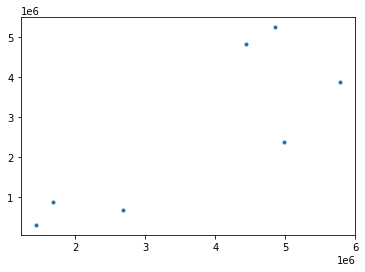

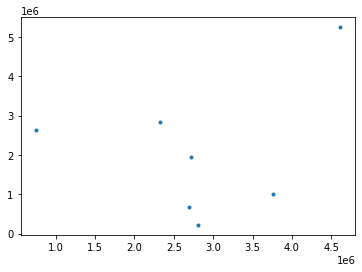

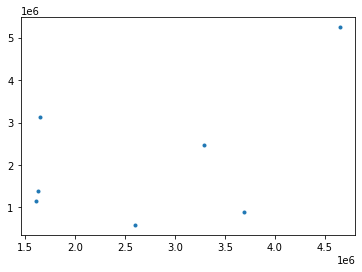

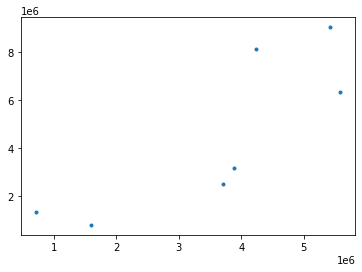

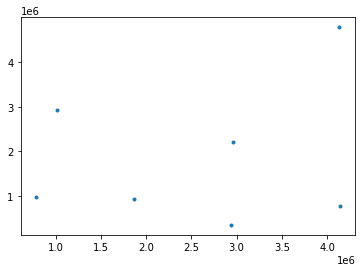

In [742]:
X = feature_df[np.array(formatted_list_name)[low_p_list]]
y = feature_df['rate']

for i in range(10):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=7/90, random_state=i)


    regr = Lasso(random_state=0, max_iter = 100000)
    regr.fit(X_train, y_train)
    #print(regr.coef_)
    #print(regr.intercept_)

    y_pred = regr.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    print("Mean Absolute Error:", mae)
    plt.figure()
    plt.plot(y_pred, y_val, '.')

In [820]:
x = 755765 /(count/250000)

full_binding_elec_data.sort_values(by='rate', ascending = False)

,sim_name,sample_num,rate,Frame,elec,sim_name_2,pairs,coulomb,nonpolar,elec_apbs,solv_free,nucl,meta_n,SASA_pairs
66,dADP_1,7,2.288824e+07,7,-72482.2730,dADP_1,43,-1.226999e+06,4924.614572,-10468.338304,-312293.510168,dADP,1,1663.757906
63,dADP_1,4,1.261581e+07,4,-71291.9849,dADP_1,55,-1.222415e+06,4679.259859,-10680.816127,-311605.237125,dADP,1,1223.878220
24,ADP_1,10,1.177313e+07,10,-71343.3946,ADP_1,26,-1.221470e+06,5050.980761,-11332.407961,-311648.843706,ADP,1,1530.745913
17,ADP_1,3,1.148334e+07,3,-70782.1070,ADP_1,60,-1.219250e+06,4769.477771,-11131.443143,-311174.511631,ADP,1,1234.866041
80,dADP_2,6,1.031526e+07,6,-72128.3969,dADP_2,22,-1.225686e+06,4868.462641,-10518.749693,-312071.847797,dADP,2,1435.322470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,dADP_1,15,3.612879e+05,15,-71644.9368,dADP_1,59,-1.223431e+06,4744.658494,-10775.723555,-311888.697206,dADP,1,1374.950049
69,dADP_1,10,3.596610e+05,10,-71844.4305,dADP_1,32,-1.224960e+06,4770.158744,-10624.279002,-312094.197754,dADP,1,1233.912659
10,ADP_0,11,2.991064e+05,11,-72003.9413,ADP_0,50,-1.225145e+06,4793.189800,-10587.291862,-312080.393975,ADP,0,1344.159406
53,dADP_0,9,2.207476e+05,9,-72191.2019,dADP_0,96,-1.226716e+06,4699.276982,-10373.150109,-312352.966463,dADP,0,1182.284011


In [33]:
myosin_struct = md.load("/home/marcus/Documents/myosin_dynamics/1qvi_MSM/bd_adp/metastable_0/cluster_1/myosin.pdb")

In [34]:
myosin_struct.xyz

array([[[17.025 , 24.1255, 15.7163],
        [17.0025, 24.1263, 15.6178],
        [17.1164, 24.0859, 15.7324],
        ...,
        [19.2841, 25.8176, 14.7228],
        [19.1742, 25.8327, 14.7758],
        [19.3869, 25.8051, 14.7946]]], dtype=float32)

In [35]:

pca_coordinates = PCA(n_components = 2)

In [36]:
pca_coordinates.fit(myosin_struct.xyz[0])

PCA(n_components=2)

In [70]:
pca_coordinates.components_[0]*5

array([-3.647189  , -3.3881803 , -0.46718425], dtype=float32)

In [38]:
myosin_struct.xyz = myosin_struct.xyz - pca_coordinates.components_[0]*5

In [39]:
# myosin_struct.save('/home/marcus/Documents/myosin_dynamics/1qvi_MSM/bd_adp/metastable_0/cluster_1/shifted_myosin.pdb')

In [71]:
actin = md.load("/home/marcus/programs/DelPhiForce/myosin_actin_test/actin.pdb")

In [72]:
actin.xyz = actin.xyz + pca_coordinates.components_[0]*5

In [73]:
# actin.save("/home/marcus/programs/DelPhiForce/myosin_actin_test/shifted_actin.pdb")

# Bootstrapping the confidence Intervals 

In [471]:
ADP_probabilities = np.concatenate(([ADP_stationary_dist[0]]*15, 
                                   [ADP_stationary_dist[1]]*15, 
                                    [ADP_stationary_dist[2]]*15))/15

ADP_all_rates = all_rates_df[0:45].rate

In [472]:
ADP_bootstrapped_rates = []
for i in range(n_bootstraps):
    estimated_rate = np.mean(np.random.choice(ADP_all_rates, p = ADP_probabilities, replace = True, size = 45))
    ADP_bootstrapped_rates.append(estimated_rate)
    

In [474]:
dADP_probabilities = np.concatenate(([dADP_stationary_dist[0]]*15, 
                                   [dADP_stationary_dist[1]]*15, 
                                    [dADP_stationary_dist[2]]*15))/15

dADP_all_rates = all_rates_df[45:90].rate


In [475]:
dADP_bootstrapped_rates = []
for i in range(n_bootstraps):
    dADP_sample = np.random.choice(dADP_all_rates, p = dADP_probabilities, replace = True, size = 45)
    estimated_rate = np.mean(dADP_sample)
    dADP_bootstrapped_rates.append(estimated_rate)
    

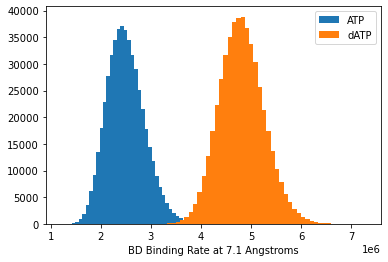

In [476]:
plt.hist(ADP_bootstrapped_rates, bins = 50, label ='ATP')
plt.hist(dADP_bootstrapped_rates, bins = 50, label = 'dATP')
plt.xlabel('BD Binding Rate at 7.1 Angstroms')
plt.legend()

In [477]:
print("Lower ADP 2.5%:", np.percentile(ADP_bootstrapped_rates,2.5))
print("Upper ADP 97.5%:", np.percentile(ADP_bootstrapped_rates,97.5))

Lower ADP 2.5%: 1834758.6196998653
Upper ADP 97.5%: 3297522.460590651


In [478]:
print("Lower dADP 2.5%:", np.percentile(dADP_bootstrapped_rates,2.5))
print("Upper dADP 97.5%:", np.percentile(dADP_bootstrapped_rates,97.5))

Lower dADP 2.5%: 3987353.66301423
Upper dADP 97.5%: 5734243.320388032


In [397]:
n_bootstraps = 500000

estimated_differenes = []

for i in range(n_bootstraps):
    ADP_sample = np.random.choice(ADP_all_rates, p = ADP_probabilities, replace = True, size = 45)
    ADP_estimated_rate = np.mean(ADP_sample)
    
    dADP_sample = np.random.choice(dADP_all_rates, p = dADP_probabilities, replace = True, size = 45)
    dADP_estimated_rate = np.mean(dADP_sample)
    
    estimated_differenes.append(dADP_estimated_rate - ADP_estimated_rate)
    
print("P-value:", np.sum(np.array(estimated_differenes)<0)/len(estimated_differenes)*2)

P-value: 0.000128


In [366]:
np.sum(np.array(estimated_differenes)<0)/len(estimated_differenes)

7e-05

In [379]:
def weighted_mean(samples, weights):
    return np.average(samples, weights=weights)

def bootstrap_weighted_mean(distribution, probabilities, n_iter=10000):
    means = []
    for _ in range(n_iter):
        sampled_indices = np.random.choice(range(len(distribution)), size=len(distribution), replace=True, p=probabilities)
        sampled_values = distribution[sampled_indices]
        sampled_weights = probabilities[sampled_indices]
        mean = weighted_mean(sampled_values, sampled_weights)
        means.append(mean)
    return np.array(means)




In [384]:
ADP_all_rates = np.array(ADP_all_rates)

dADP_all_rates = np.array(dADP_all_rates)

### Bootstrapping the CI over a range of distnaces 

In [538]:
def get_bd_rates(bd_sim, distance):
    output_rates = np.zeros(len(bd_sim.sim_list))
    
    i = 0
    for input_df in bd_sim.sim_list:
        output_rates[i] = np.interp(distance, input_df.distance, input_df.average)
        i+=1
    
    return output_rates


In [659]:
# Inputs should be something like bd_sim_list = [ADP_0,ADP_1,ADP_2], stationary_distribution = ADP_stationary_dist

def bootstrap_CI(bd_sim_list, stationary_dist, lower_bound=0, upper_bound=15, n_points=50, CI = 95, n_bootstraps = 20000):
    # Create array of values to calculate the CI at
    data_range = np.linspace(lower_bound, upper_bound, n_points)
    
    # Create a probabilities array 
    n_metastable_samples = 0
    n_metastable = len(bd_sim_list)
    n_meta_per = len(bd_sim_list[0].sim_list)
    for sim in bd_sim_list:
        n_metastable_samples += len(sim.sim_list)
    
    n_metastable_samples//n_metastable
    all_probabilities = []
    for i in range(n_metastable):
        all_probabilities = np.concatenate((all_probabilities,
            np.full(n_meta_per, stationary_dist[i]/n_meta_per)))
    
    # Test the probailities are correct
    assert np.sum(all_probabilities) <= 1.000001 or np.sum(all_probabilities) >= 0.999999 
    
    lower_array = np.zeros(n_points)
    upper_array = np.zeros(n_points)
    lower_percent = (100-CI)/2
    upper_percent = 100 - (100-CI)/2
    
    print(lower_percent, upper_percent)
    
    ind = 0 
    for x in tqdm(data_range):
        sim_all_rates = []
        for bd_sim in bd_sim_list:
            
            sim_all_rates = np.concatenate((sim_all_rates,get_bd_rates(bd_sim, x)))
        
        # Defined in the input function 
        # Default is 20,000
        n_samples = n_bootstraps
        rates = np.mean(np.random.choice(sim_all_rates,
                                         p = all_probabilities,
                                         size = (n_metastable_samples,n_samples),
                                         replace = True),
                        axis = 0)
        
        lower_array[ind] = np.percentile(rates, lower_percent)
        upper_array[ind] = np.percentile(rates, upper_percent)
        
        ind += 1 
        

    return data_range, lower_array, upper_array
    


In [662]:
bootstrap_CI([ADP_0, ADP_1, ADP_2],
    ADP_stationary_dist,
    exp_distance,exp_distance,1,  95, 50000)

2.5 97.5


100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.77it/s]


(array([7.20322589]), array([1829933.92284265]), array([3297231.4453938]))

In [668]:
bootstrap_CI([dADP_0, dADP_1, dADP_2],
    dADP_stationary_dist,
    exp_distance,exp_distance,1,  95, 50000)

2.5 97.5


100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.77it/s]


(array([7.20322589]), array([3988031.01920849]), array([5726529.46000896]))

1835292.4982807874
3304912.7812953726


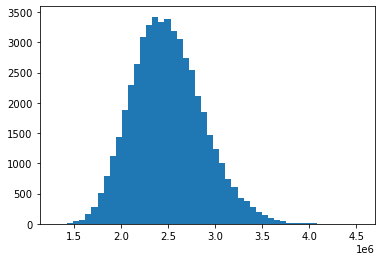

In [482]:
n_samples = 50000
test = np.mean(np.random.choice(ADP_all_rates, p = ADP_probabilities, size = (45,n_samples),replace = True),axis = 0)

plt.hist(test, bins = 50)

print(np.percentile(test,2.5))
print(np.percentile(test,97.5))


In [664]:
x_range, lower_ADP, upper_ADP = bootstrap_CI([ADP_0, ADP_1, ADP_2],
                                             ADP_stationary_dist,
                                             5,15,50,  95, 50000)

2.5 97.5


100%|███████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.65it/s]


In [665]:
x_range, lower_dADP, upper_dADP = bootstrap_CI([dADP_0, dADP_1, dADP_2],
                                             dADP_stationary_dist,
                                             5,15,50,  95, 50000)

2.5 97.5


100%|███████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.13it/s]


(0.0, 100000000.0)

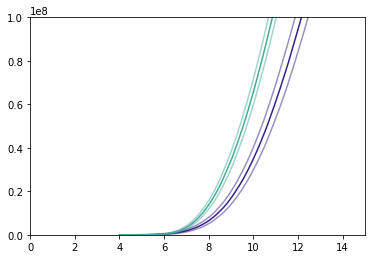

In [544]:
plt.plot(x_range, lower_ADP, c = colors[0], alpha = 0.5)
plt.plot(x_range, upper_ADP, c = colors[0], alpha = 0.5)
plt.plot(ADP_0.distance_range, ADP_averaged, label = 'ATP Binding Curve', c= colors[0])
plt.xlim(0,15)
plt.ylim(0,1e8)

plt.plot(x_range, lower_dADP, c = colors[1], alpha = 0.5)
plt.plot(x_range, upper_dADP, c = colors[1], alpha = 0.5)
plt.plot(dADP_0.distance_range, dADP_averaged, label = 'dATP Binding Curve', c= colors[1])
plt.xlim(0,15)
plt.ylim(0,1e8)

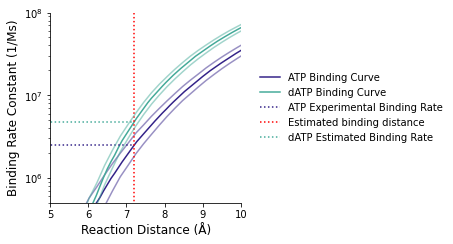

In [547]:
fig = plt.figure(figsize = (8.7/2.54,3.5))
plt.plot(ADP_0.distance_range, ADP_averaged, label = 'ATP Binding Curve', c= colors[0])
plt.plot(x_range, lower_ADP, c = colors[0], alpha = 0.5)
plt.plot(x_range, upper_ADP, c = colors[0], alpha = 0.5)

plt.plot(dADP_0.distance_range, dADP_averaged, label = 'dATP Binding Curve', c= colors[1])
plt.plot((0, exp_distance),(2.5e6,2.5e6),':', c = colors[0], label = 'ATP Experimental Binding Rate')
plt.plot((exp_distance, exp_distance),(0,1e8),':r', label = 'Estimated binding distance ')

plt.plot((0,exp_distance),(dADP_rate,dADP_rate),':', c=colors[1], label = 'dATP Estimated Binding Rate')
plt.plot(x_range, lower_dADP, c = colors[1], alpha = 0.5)
plt.plot(x_range, upper_dADP, c = colors[1], alpha = 0.5)


plt.legend(loc = 'upper left', fontsize = 9)
plt.xlim(5,10)

plt.yscale('log')
plt.ylim(.5e6,1e8)
plt.xlabel('Reaction Distance (Å)', fontsize = 12)
plt.ylabel('Binding Rate Constant (1/Ms)', fontsize = 12)
lgd = plt.legend(loc='center right', 
           bbox_to_anchor=(2.1, .5),

          ncol=1, fancybox=True, shadow=False, 
          frameon = False)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)

1835292.4982807874
3304912.7812953726


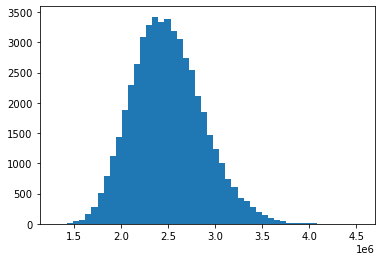

In [482]:
n_samples = 50000
test = np.mean(np.random.choice(ADP_all_rates, p = ADP_probabilities, size = (45,n_samples),replace = True),axis = 0)

plt.hist(test, bins = 50)

print(np.percentile(test,2.5))
print(np.percentile(test,97.5))


(array([3.000e+00, 6.000e+00, 1.600e+01, 6.500e+01, 1.700e+02, 3.550e+02,
        6.030e+02, 1.018e+03, 1.499e+03, 2.040e+03, 2.568e+03, 3.150e+03,
        3.666e+03, 3.828e+03, 4.029e+03, 3.879e+03, 3.635e+03, 3.257e+03,
        2.932e+03, 2.612e+03, 2.128e+03, 1.872e+03, 1.537e+03, 1.193e+03,
        9.670e+02, 7.730e+02, 5.800e+02, 4.220e+02, 3.150e+02, 2.640e+02,
        1.800e+02, 1.340e+02, 8.800e+01, 6.700e+01, 4.500e+01, 3.100e+01,
        2.000e+01, 1.900e+01, 9.000e+00, 7.000e+00, 8.000e+00, 3.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([0.90903351, 0.97517007, 1.04130662, 1.10744317, 1.17357972,
        1.23971627, 1.30585283, 1.37198938, 1.43812593, 1.50426248,
        1.57039903, 1.63653559, 1.70267214, 1.76880869, 1.83494524,
        1.90108179, 1.96721835, 2.0333549 , 2.09949145, 2.165628  ,
        2.23176455, 2.29790111, 2.36403766, 2.43017421, 2.49631076,
        2.56244732, 2.62858387, 2.69

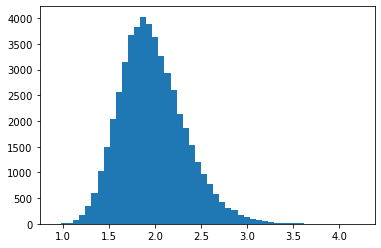

In [666]:
n_samples = 50000

ADP_sampled_rates = np.random.choice(ADP_all_rates,
                 p = ADP_probabilities,
                 size = (45,n_samples),
                 replace = True)


dADP_sampled_rates = np.random.choice(dADP_all_rates,
                 p = dADP_probabilities,
                 size = (45,n_samples),
                 replace = True)




ratios = np.mean(dADP_sampled_rates, axis = 0)/np.mean(ADP_sampled_rates, axis = 0)

plt.hist(ratios, bins = 50)

#np.mean(ratios<1)

In [667]:
print("Lower percentile (2.5%):", np.percentile(ratios, 2.5))
print("Upper percentile (97.5%):",np.percentile(ratios, 97.5))

Lower percentile (2.5%): 1.3756850929478104
Upper percentile (97.5%): 2.7520412928586158


case 4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
case 4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
case 4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
case 4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
case 4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
case 4
1
2
3
4
5
6
7
8
9
10
11
12
13
14


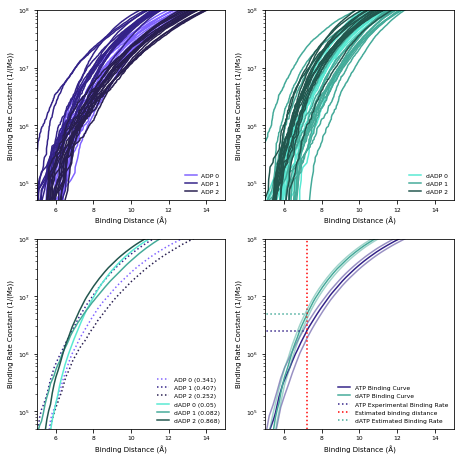

In [2]:
fig, ax = plt.subplots(2,2,figsize = (6.5, 6.5))


ADP_0.plot_all(color = ADP_colors[0], label = 'ADP 0', ax = ax[0,0])
ADP_1.plot_all(color = ADP_colors[1], label = 'ADP 1', ax = ax[0,0])
ADP_2.plot_all(color = ADP_colors[2], label = 'ADP 2', ax = ax[0,0])

dADP_0.plot_all(color = dADP_colors[0], label = 'dADP 0', ax = ax[0,1])
dADP_1.plot_all(color = dADP_colors[1], label = 'dADP 1', ax = ax[0,1])
dADP_2.plot_all(color = dADP_colors[2], label = 'dADP 2', ax = ax[0,1])

ax[1,0].plot(ADP_0.distance_range, ADP_0.average, ':', label = 'ADP 0 ({})'.format(np.round(ADP_stationary_dist[0],3)), color = ADP_colors[0])
ax[1,0].plot(ADP_1.distance_range, ADP_1.average, ':',label = 'ADP 1 ({})'.format(np.round(ADP_stationary_dist[1],3)), color = ADP_colors[1])
ax[1,0].plot(ADP_2.distance_range, ADP_2.average, ':',label = 'ADP 2 ({})'.format(np.round(ADP_stationary_dist[2],3)), color = ADP_colors[2])

ax[1,0].plot(dADP_0.distance_range, dADP_0.average, label = 'dADP 0 ({})'.format(np.round(dADP_stationary_dist[0],3)), color = dADP_colors[0])
ax[1,0].plot(dADP_1.distance_range, dADP_1.average, label = 'dADP 1 ({})'.format(np.round(dADP_stationary_dist[1],3)), color = dADP_colors[1])
ax[1,0].plot(dADP_2.distance_range, dADP_2.average, label = 'dADP 2 ({})'.format(np.round(dADP_stationary_dist[2],3)), color = dADP_colors[2])






ax[1,1].plot(ADP_0.distance_range, ADP_averaged, label = 'ATP Binding Curve', c= colors[0])
ax[1,1].plot(x_range, lower_ADP, c = colors[0], alpha = 0.5)
ax[1,1].plot(x_range, upper_ADP, c = colors[0], alpha = 0.5)

ax[1,1].plot(dADP_0.distance_range, dADP_averaged, label = 'dATP Binding Curve', c= colors[1])
ax[1,1].plot((0, exp_distance),(2.5e6,2.5e6),':', c = colors[0], label = 'ATP Experimental Binding Rate')
ax[1,1].plot((exp_distance, exp_distance),(0,1e8),':r', label = 'Estimated binding distance ')

ax[1,1].plot((0,exp_distance),(dADP_rate,dADP_rate),':', c=colors[1], label = 'dATP Estimated Binding Rate')
ax[1,1].plot(x_range, lower_dADP, c = colors[1], alpha = 0.5)
ax[1,1].plot(x_range, upper_dADP, c = colors[1], alpha = 0.5)



for i in range(4):
    ax[i//2, i % 2].legend(loc = 'upper left')

    ax[i//2, i % 2].set_xlim(5,15)
    ax[i//2, i % 2].legend(frameon = False, fontsize = 6, loc = 'lower right')

    ax[i//2, i % 2].set_ylim(0,2e8)
    

    ax[i//2, i % 2].set_xlabel('Binding Distance (Å)', fontsize = 7)
    ax[i//2, i % 2].set_ylabel('Binding Rate Constant (1/(Ms))', fontsize = 7)
    ax[i//2, i % 2].set_yscale('log')
    ax[i//2, i % 2].set_ylim(.5e5,1e8)
    ax[i//2, i % 2].tick_params(axis='both', which='major', labelsize=6)
    ax[i//2, i % 2].tick_params(axis='both', which='minor', labelsize=6)
#    ax[i//2, i % 2].


plt.tight_layout()
# fig.savefig('../figures/all_bd_binding_and_weighted_and_CI.svg')

In [1]:
import dill
#dill.dump_session('BD_Results_Analysis_070524.db')
#dill.load_session('BD_Results_Analysis_070524.db')


In [13]:
# Three metastable states 
adp_hydro_radii = []

for i in range(3):
    # 15 sampled conformations 
    for j in range(15):
        f = open('/home/marcus/Documents/myosin_dynamics/1qvi_MSM/bd_adp/metastable_{}/cluster_{}/myosin_hydro_params.xml'.format(i,j+1), 'r')
        lines = f.readlines()
        for line in lines:
            if "radius" in line:
                radius = float(line.split()[1])
                adp_hydro_radii.append(radius)
#        print(lines)

In [14]:
# Three metastable states 
dadp_hydro_radii = []

for i in range(3):
    # 15 sampled conformations 
    for j in range(15):
        f = open('/home/marcus/Documents/myosin_dynamics/1qvi_MSM/bd_dadp/metastable_{}/cluster_{}/myosin_hydro_params.xml'.format(i,j+1), 'r')
        lines = f.readlines()
        for line in lines:
            if "radius" in line:
                radius = float(line.split()[1])
                dadp_hydro_radii.append(radius)
#        print(lines)

In [28]:
feature_df['hydro_radii'] = np.concatenate((adp_hydro_radii, dadp_hydro_radii))

feature_df['nucleotide'] = np.concatenate((['ADP']*45, ['dADP']*45))

<AxesSubplot:xlabel='sim_name', ylabel='hydro_radii'>

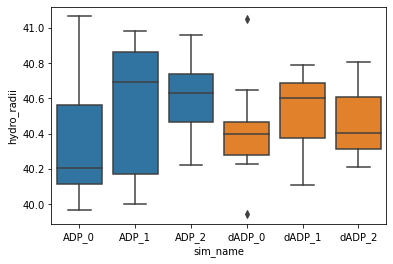

In [26]:
sns.boxplot(data = feature_df, x = 'sim_name', y = 'hydro_radii', 
            palette = ['C0','C0','C0','C1','C1','C1'])

In [22]:
corr_r, p_val = stats.spearmanr(feature_df['hydro_radii'], feature_df.rate)

Pearson correlation coefficient: 0.06
P-value: 6.055e-01


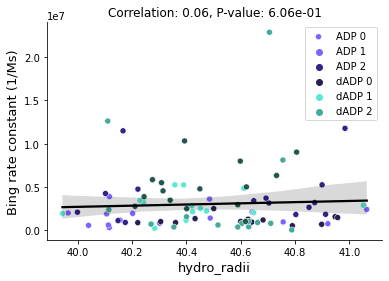

In [24]:
counter = 0
low_p_list = []
for feature in ['hydro_radii']:
    
    corr_r, p_val = stats.spearmanr(feature_df[feature], feature_df.rate)
    #if p_val <= 0.05:
    plt.figure()

    sns.scatterplot(data=feature_df, 
            x=feature, 
            y='rate', 
            hue='sim_name', 
            palette=combined_colors)

    # Add a regression line using regplot with the same DataFrame and x, y axes
    # Set scatter=False to avoid duplicating points
    sns.regplot(data=feature_df, 
                x=feature, 
                y='rate', 
                scatter=False, 
                line_kws={'color': 'black'})  # Customize the color of the line

    # Calculate the Pearson correlation coefficient and p-value
    correlation, p_value = pearsonr(feature_df[feature], feature_df['rate'])
    print("Pearson correlation coefficient: {:.2f}".format(correlation))
    print("P-value: {:.3e}".format(p_value))

    # Customize the legend for the scatterplot
    plt.legend(['ADP 0','ADP 1','ADP 2','dADP 0','dADP 1','dADP 2'])
    plt.title(f'Correlation: {correlation:.2f}, P-value: {p_value:.2e}')
    plt.ylabel('Bing rate constant (1/Ms)', fontsize = 13)
    plt.xlabel(feature,fontsize = 13)
    # Remove the top right borders 
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)


        ## plt.savefig("../figures/feature_{}_corr.png".format(feature), dpi = 900)
    # else:
        # plt.title('{:.2f} {:.2e} '.format(corr_r, p_val), color = 'black')
    plt.show()
    counter +=1 

<AxesSubplot:xlabel='hydro_radii', ylabel='rate'>

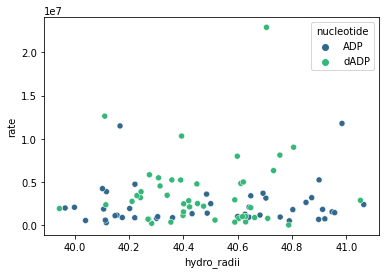

In [36]:
sns.scatterplot(data = feature_df, x = 'hydro_radii',y = 'rate', hue = 'nucleotide', palette = 'viridis')

<AxesSubplot:xlabel='hydro_radii', ylabel='Density'>

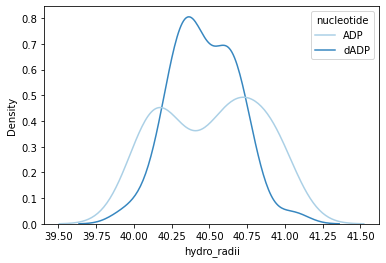

In [43]:
sns.kdeplot(data = feature_df, x = 'hydro_radii', hue = 'nucleotide', palette = 'Blues')

In [44]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [46]:
# Perform ANOVA
model = ols('hydro_radii ~ C(sim_name)', data=feature_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

               sum_sq    df         F    PR(>F)
C(sim_name)  0.634996   5.0  1.720336  0.138801
Residual     6.201075  84.0       NaN       NaN


In [49]:
feature_df[['hydro_radii','sim_name']].to_excel('hydro_radii_for_anova.xlsx')
